In [9]:
# Neural Bayes-DML
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.autograd as autograd
from torch.autograd import Variable
import math

import torch.utils.data as data
import torch.nn as nn
import torch.nn.init as init
import torchvision.transforms as transforms
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['grid.color'] = 'k'
matplotlib.rcParams['grid.linestyle'] = ':'
matplotlib.rcParams['grid.linewidth'] = 0.5

from sklearn.datasets import make_moons
import sklearn
from sklearn import datasets
from matplotlib import pyplot
from pandas import DataFrame
from argparse import Namespace
import seaborn as sns
sns.set()
import pickle as pkl

use_cuda=False

In [10]:
class MLPNet(nn.Module):
    def __init__(self, dim_inp=None, dim_out=None, nhiddens=[400, 400, 400], bn=True):
        super(MLPNet, self).__init__()
        self.dim_inp = dim_inp
        self.layers = nn.ModuleList([])
        for l in range(len(nhiddens)):
            if l==0:
                layer = nn.Linear(dim_inp, nhiddens[l], bias=False)
            else:
                layer = nn.Linear(nhiddens[l-1], nhiddens[l], bias=False)
            self.layers.append(layer)
            bn_layer = nn.BatchNorm1d(nhiddens[l]) if bn else nn.Sequential()
            relu_layer = nn.ReLU(inplace=True)
            self.layers.extend([bn_layer, relu_layer])
            
        fc = nn.Linear(nhiddens[-1], dim_out, bias=False)
        self.layers.append(fc)
        self.net = nn.Sequential(*self.layers)
        
        self.nhiddens = nhiddens
        
    def forward(self, x, logit=False):
        x = x.view(-1, self.dim_inp)
        x = self.net(x)
        out = torch.nn.Softmax(dim=1)(x)
        if logit:
            return x 
        return out


In [11]:
def get_rot_mat(angle=0):
    angle = np.pi* angle/180.
    R = np.zeros((2,2))
    R[0,0] = np.cos(angle)
    R[0,1] = -np.sin(angle)
    R[1,0] = np.sin(angle)
    R[1,1] = np.cos(angle)
    return R

In [12]:
def generate_meshgrid(opt):
    xx, yy = np.meshgrid(np.linspace(-opt.MGR * opt.R, opt.MGR * opt.R, int(opt.MGR * opt.MGRN)),
                         np.linspace(-opt.MGR * opt.R, opt.MGR * opt.R, int(opt.MGR * opt.MGRN)))
    return xx, yy

def to_torch_meshgrid(xx, yy, Proj=None):
    xxyy = np.concatenate((xx[..., None], yy[..., None]), axis=-1)
    xxyy = xxyy.reshape(-1, xxyy.shape[-1])
#     print(xxyy.shape)
    if Proj is not None:
        X_ = np.zeros((xxyy.shape[0], 512), dtype='float32')
        X_[:, :2] = xxyy
        xxyy = np.dot(X_, Proj.T)
    
    xxyy = torch.from_numpy(xxyy).float()
    if use_cuda:
        xxyy = xxyy.cuda()
    return xxyy

def to_torch_dataset_2d(xs, ys, z):
    xy = np.concatenate((xs[:, None], ys[:, None]), axis=1).astype('float32')
    xy = torch.from_numpy(xy)
    z = torch.from_numpy(z[:, None]).float()
    if use_cuda: 
        xy = xy.cuda()
        z = z.cuda()
    return xy, z

# ---- Set up cmaps ----
cmapd = sns.diverging_palette(250, 10, s=75, l=40, center='dark', as_cmap=True)
cmap = sns.diverging_palette(250, 10, s=75, l=40, center='light', as_cmap=True)
# -----
cmap2 = sns.diverging_palette(145, 280, s=85, l=25, as_cmap=True)
cmap2d = sns.diverging_palette(145, 280, s=85, l=25, center='dark', as_cmap=True)
# -----
cmap3 = sns.diverging_palette(220, 20, as_cmap=True)
cmap3d = sns.diverging_palette(220, 20, center='dark', as_cmap=True)
    
    
def plot_model2(opt, model, xy=None, z_gt=None, scatter_alpha=0.5, dim_out=2, plot=True, Proj=None):
    xy0 = 1.*xy
    if Proj is not None:
        xy = np.dot(xy, Proj)[:,:2]
    plt.figure(figsize=(5,3))
    if dim_out<0:
        colors = ['red','green','blue','black', 'magenta','cyan'][:opt.dim_out]
        cmap=matplotlib.colors.ListedColormap(colors)
    else:
        cmap = plt.cm.get_cmap("rainbow", max([2,dim_out]))
    
    model.eval()
    z_xy = (model(Variable(torch.FloatTensor(xy0).cuda()))).data.cpu().numpy()
    xx, yy = generate_meshgrid(opt)
    im_shape = xx.shape
    xxyy = Variable(to_torch_meshgrid(xx, yy, Proj=Proj).cuda())
    
    z=(model(xxyy)).data.cpu().numpy()
#     print(xy.shape, z_xy.shape, xxyy.data.size(), z.shape)
    if dim_out>1:
        z = np.argmax(z, axis=1)
        z_xy = np.argmax(z_xy, axis=1)
    else:
        z = z* (z>0.5)
        z_xy = z_xy* (z_xy>0.5)
        
    z = z.reshape(*im_shape)
    z_xy = z_xy.reshape(-1)
    
    # Plot
    plt.figure(figsize=(6, 6))
    plt.xlim(-opt.plot_xlim, opt.plot_xlim)
    plt.ylim(-opt.plot_ylim, opt.plot_ylim)
    plt.grid(False)
    plt.contourf(xx, yy, z, alpha=0.1, cmap=cmap)
    plt.scatter(xy[:, 0], xy[:, 1], c=z_xy, s=25, cmap=cmap, alpha=scatter_alpha)
    if plot:
        plt.show()
    return plt

def bin2dec(x):
    n = np.zeros((x.shape[0]))
    for i in range(x.shape[1]):
        n += x[:,-i-1]* (2**i)
    return n


def get_gaussian_data(n_samples=1000, noise=0.1):
    x0 = noise* np.random.randn(n_samples//2,2) - 2.
    x1 = noise* np.random.randn(n_samples//2,2) + 2.
    X = np.concatenate((x0,x1))
    y = np.concatenate( (np.zeros((x0.shape[0],)), np.ones((x1.shape[0],) )), axis=0)
    mn = X.mean(axis=0)
    std = X.std(axis=0)
    X -= mn[None,:]
    X /= 1.*std[None,:]
    y = y.reshape(-1,1)
    return X,y

def get_blob_data(n_samples=1000, n_samples_test=1, noise=1., hd=False):
    Proj = None
    X,Y = sklearn.datasets.make_blobs(n_samples=n_samples+n_samples_test, n_features=2, centers=3, cluster_std=noise, \
                                  center_box=(-5.0, 5.0), shuffle=True, random_state=None)
    transformation = [[0.6, -0.6], [-0.4, 1.1]]
#     transformation = [[0.6, -0.6], [-0.4, 0.8]]
    X = np.dot(X, transformation)
    mn = X.mean(axis=0)
    std = X.std(axis=0)
    X -= mn[None,:]
    X /= 1.*std[None,:]
    Y = Y.reshape(-1,1)
    
    if hd:
        Proj = np.random.randn(512, 512)
        Proj,_,_ = np.linalg.svd(Proj)
        X_ = np.zeros((X.shape[0], 512), dtype='float32')
        X_[:, :2] = X
        X = np.dot(X_, Proj.T)
        
    X_train = X[:n_samples]
    Y_train = Y[:n_samples]
    X_test = X[n_samples:]
    Y_test = Y[n_samples:]
    
    return X_train,Y_train,X_test,Y_test, Proj

def get_circles_data(n_samples=1000, noise=0.01, factor=0.8, hd=False):
    Proj = None
    X,y = sklearn.datasets.make_circles(n_samples=n_samples, shuffle=True, noise=noise, random_state=None,\
                                        factor=factor)
    mn = X.mean(axis=0)
    std = X.std(axis=0)
    X -= mn[None,:]
    X /= 1.*std[None,:]
    y = y.reshape(-1,1)
    if hd:
        Proj = np.random.randn(512, 512)
        Proj,_,_ = np.linalg.svd(Proj)
        X_ = np.zeros((X.shape[0], 512), dtype='float32')
        X_[:, :2] = X
        X = np.dot(X_, Proj.T)
    return X,y, Proj

def get_moon_data(n_samples=1000, n_samples_test=1, noise=0.01, outlier_distance=2., n_outliers=0, hd=False):
    Proj = None
    X, Y = make_moons(n_samples=n_samples+n_samples_test, noise=noise)
        
    X_train = X[:n_samples]
    Y_train = Y[:n_samples].reshape(-1,1)
    mn = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    X_train -= mn[None,:]
    X_train /= 1.*std[None,:]
    if n_outliers>0:
        ind = np.random.permutation(X_train.shape[0])[:n_outliers]
        X_train[ind,:] =  X_train[ind,:] + np.stack((X_train[ind,0],np.sign(X_train[ind,1])* outlier_distance)).T

    X_test = X[n_samples:]
    Y_test = Y[n_samples:].reshape(-1,1)
    X_test -= mn[None,:]
    X_test /= 1.*std[None,:]
    
    if hd:
        Proj = np.random.randn(512, 512)
        Proj,_,_ = np.linalg.svd(Proj)
        X_ = np.zeros((X_train.shape[0], 512), dtype='float32')
        X_[:, :2] = X_train
        X_train = np.dot(X_, Proj.T)
        
        X_ = np.zeros((X_test.shape[0], 512), dtype='float32')
        X_[:, :2] = X_test
        X_test = np.dot(X_, Proj.T)
    return X_train,Y_train,X_test, Y_test, Proj

def twospirals(n_points, angle=180, noise=.5, hd=False):
    """
     Returns the two spirals dataset.
    """
    Proj = None
    R1 = get_rot_mat(angle=120).T
    R2 = get_rot_mat(angle=240).T
    n = 1 + np.sqrt(np.random.rand(n_points,1)) * 780 * ((angle/180.)* np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    X1 = np.hstack((d1x,d1y))
    X2 = np.dot(X1, R1)
    X3 = np.dot(X1, R2)
    X = np.vstack((X1,X2,X3 ))
#     X = np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)),np.hstack((-d1y,d1x)) ))
    Y = np.hstack((np.zeros(n_points),np.ones(n_points),2*np.ones(n_points)))
    if hd:
        Proj = np.random.randn(512, 512)
        Proj,_,_ = np.linalg.svd(Proj)
        X_ = np.zeros((X.shape[0], 512), dtype='float32')
        X_[:, :2] = X
        X = np.dot(X_, Proj.T)
    return X, Y, Proj


def get_opt(X, dim_out=2):
    opt = Namespace()
#     opt.plot_xlim = 0.5+np.max(np.abs(X), axis=0)[0]
#     opt.plot_ylim = 2.+np.max(np.abs(X), axis=1)[0]
#     opt.plot_xlim = 2+np.max(np.abs(X), axis=0)[0]
#     opt.plot_ylim = 4.+np.max(np.abs(X), axis=1)[0]
    opt.plot_xlim = 5+np.max(np.abs(X), axis=0)[0]
    opt.plot_ylim = 7.+np.max(np.abs(X), axis=1)[0]
    opt.R = 4.*max([opt.plot_ylim, opt.plot_xlim])
    opt.MGR = 0.5 # 2.5
    opt.MGRN = 200
    opt.save_dir = 'models'
    opt.dim_out = dim_out
    return opt

def sampleX(X, bs=50):
    batch_ind = np.random.permutation(X.shape[0])[:bs]
    return Variable(torch.FloatTensor(X[batch_ind]))

def sampleXY(X, Y, bs=50):
    Y=Y.reshape(-1)
    batch_ind = np.random.permutation(X.shape[0])[:bs]
    return Variable(torch.FloatTensor(X[batch_ind])), Variable(torch.LongTensor(Y[batch_ind]))


In [13]:
def get_noise(x):
    sz = x.size()
    x = x.view(x.size(0), -1)
    mn = x.mean(dim=0, keepdim=True)
    x = x-mn
    eps = torch.randint(0,2, (x.size(0), x.size(0))).cuda(). type('torch.cuda.FloatTensor')
    noise = torch.mm(x.t(), eps).t()
    norm = torch.norm(noise, dim=1, keepdim=True)
    assert not np.any(norm.detach().cpu().numpy()==0), '0 norm {}'.format(torch.min(norm))
    noise = noise/norm
    return noise.view(sz)

In [16]:
def train_DML(plot=True, config=None, data=None, Proj=None):
    if config is None:
        print('No config provided!')
        exit(0)
    assert config.dim_out>1, 'dim_out must be greater than 2 for calling train_DML'
    X,Y = data
    model = MLPNet(dim_inp = X.shape[1],nhiddens=config.hid_dim, dim_out=config.dim_out, bn=config.bn).cuda()
    params = list(model.parameters())

    optimizer = torch.optim.Adam(params,\
                                   lr=config.LEARNING_RATE, weight_decay=config.WD) # , betas=(-0.9, 0.999)
    
    epoch = 0
    last_epoch = 0
    iter_ = -1
    loss = 9999
    loss_epoch_list=[]
    loss_list = []
    flag=0
    CE_ind=0



    if plot:
        opt = get_opt(X,dim_out=config.dim_out)
        pred = (model(Variable(torch.FloatTensor(X).cuda()))).data.cpu().numpy()
        pred = np.argmax(pred, axis=1)
        plot_model2(opt, model, xy=X, z_gt=pred.reshape(-1), scatter_alpha=0.5, dim_out=config.dim_out, Proj=Proj)

    while epoch<config.EPOCHS:
        iter_ += 1
        if iter_%(X.shape[0]/float(config.bs))==0 and iter_!=0:
            epoch+=1
            if len(loss_epoch_list)>0:
                loss_list.append(sum(loss_epoch_list)/len(loss_epoch_list))
                loss_epoch_list = []
                
        model.train()
    
        optimizer.zero_grad()  
        b_x0 = sampleX(X, bs=config.bs).cuda()
        noise =  0.1* torch.randn( 1).cuda()*get_noise(b_x0) # b_x0.size(0),1
        b_x = b_x0 + noise


        Lx = (model(b_x0))#+ config.epsilon
        ELx = torch.mean(Lx, dim=0,keepdim=True) # 

        fx = (Lx)/(ELx)  + config.epsilon
        fx_bar = (1.-Lx)/(1.-ELx) + config.epsilon
        
        loss = (fx* torch.log(1. + fx_bar/fx) + fx_bar* torch.log(1. + fx/fx_bar)).mean()
        L = loss

        if math.isnan(L):
            flag=1
            print('NaN encountered, exiting training.')
            break
            exit()
        L.backward()  

        loss_epoch_list.append(L)

        beta = config.beta
        grad_penalty=0
        if config.beta>0:
            Lx0 = (model(b_x0, True))#+ config.epsilon
            Lx = (model(b_x, True))
            grad_penalty = ( ((Lx-Lx0)**2).sum(dim=1)/((b_x-b_x0)**2).sum(dim=1) ).mean()
            grad_penalty.backward()  

        optimizer.step()
        optimizer.zero_grad() 


        if epoch%1==0 and epoch!=last_epoch:
            last_epoch = epoch
            print('Epoch {:3d} ({:4d}) | loss {:.3f} | LR {:.4f} | beta {:.4f} | jac {}'\
                  .format(epoch,iter_, loss_list[-1], config.LEARNING_RATE, beta, grad_penalty))
            if plot and epoch%10==0:
                pred = (model(Variable(torch.FloatTensor(X).cuda()))).data.cpu().numpy()
                pred = np.argmax(pred, axis=1)
                plot_model2(opt, model, xy=X, z_gt=pred.reshape(-1), scatter_alpha=0.9,\
                            dim_out=config.dim_out, Proj=Proj)
    return loss_list, model,flag


config=Namespace()
config.LEARNING_RATE = 0.001
config.WD = 0.000
config.bn = True
config.hid_dim =  [400]*4
config.epsilon=1e-7


<Figure size 360x216 with 0 Axes>

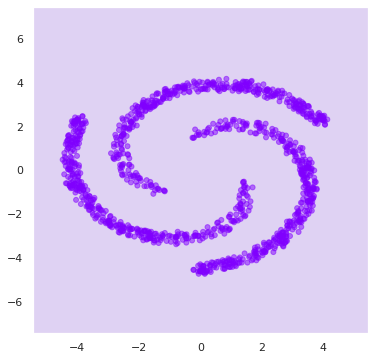

Epoch   1 (   1) | loss 1.370 | LR 0.0010 | beta 1.0000 | jac 0.08096475154161453
Epoch   2 (   2) | loss 1.362 | LR 0.0010 | beta 1.0000 | jac 0.049936018884181976
Epoch   3 (   3) | loss 1.342 | LR 0.0010 | beta 1.0000 | jac 0.050259802490472794
Epoch   4 (   4) | loss 1.269 | LR 0.0010 | beta 1.0000 | jac 0.07821021974086761
Epoch   5 (   5) | loss 1.171 | LR 0.0010 | beta 1.0000 | jac 0.10923154652118683
Epoch   6 (   6) | loss 1.067 | LR 0.0010 | beta 1.0000 | jac 0.14878003299236298
Epoch   7 (   7) | loss 0.955 | LR 0.0010 | beta 1.0000 | jac 0.18159735202789307
Epoch   8 (   8) | loss 0.856 | LR 0.0010 | beta 1.0000 | jac 0.22101156413555145
Epoch   9 (   9) | loss 0.772 | LR 0.0010 | beta 1.0000 | jac 0.2559066414833069
Epoch  10 (  10) | loss 0.700 | LR 0.0010 | beta 1.0000 | jac 0.252158522605896


<Figure size 360x216 with 0 Axes>

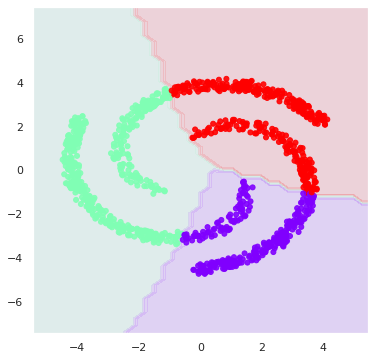

Epoch  11 (  11) | loss 0.646 | LR 0.0010 | beta 1.0000 | jac 0.28991439938545227
Epoch  12 (  12) | loss 0.607 | LR 0.0010 | beta 1.0000 | jac 0.3034490644931793
Epoch  13 (  13) | loss 0.574 | LR 0.0010 | beta 1.0000 | jac 0.3213469088077545
Epoch  14 (  14) | loss 0.551 | LR 0.0010 | beta 1.0000 | jac 0.3124444782733917
Epoch  15 (  15) | loss 0.531 | LR 0.0010 | beta 1.0000 | jac 0.30827754735946655
Epoch  16 (  16) | loss 0.515 | LR 0.0010 | beta 1.0000 | jac 0.3105575740337372
Epoch  17 (  17) | loss 0.500 | LR 0.0010 | beta 1.0000 | jac 0.31123942136764526
Epoch  18 (  18) | loss 0.481 | LR 0.0010 | beta 1.0000 | jac 0.3387828469276428
Epoch  19 (  19) | loss 0.464 | LR 0.0010 | beta 1.0000 | jac 0.3406955599784851
Epoch  20 (  20) | loss 0.451 | LR 0.0010 | beta 1.0000 | jac 0.36480382084846497


<Figure size 360x216 with 0 Axes>

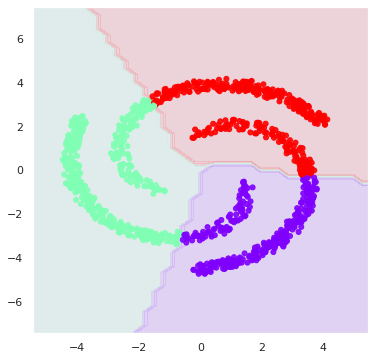

Epoch  21 (  21) | loss 0.434 | LR 0.0010 | beta 1.0000 | jac 0.3637242317199707
Epoch  22 (  22) | loss 0.425 | LR 0.0010 | beta 1.0000 | jac 0.3394125998020172
Epoch  23 (  23) | loss 0.424 | LR 0.0010 | beta 1.0000 | jac 0.3675841987133026
Epoch  24 (  24) | loss 0.422 | LR 0.0010 | beta 1.0000 | jac 0.3342423141002655
Epoch  25 (  25) | loss 0.425 | LR 0.0010 | beta 1.0000 | jac 0.366271048784256
Epoch  26 (  26) | loss 0.427 | LR 0.0010 | beta 1.0000 | jac 0.3727892339229584
Epoch  27 (  27) | loss 0.432 | LR 0.0010 | beta 1.0000 | jac 0.2992902100086212
Epoch  28 (  28) | loss 0.440 | LR 0.0010 | beta 1.0000 | jac 0.3088088929653168
Epoch  29 (  29) | loss 0.438 | LR 0.0010 | beta 1.0000 | jac 0.32136136293411255
Epoch  30 (  30) | loss 0.431 | LR 0.0010 | beta 1.0000 | jac 0.3284926414489746


<Figure size 360x216 with 0 Axes>

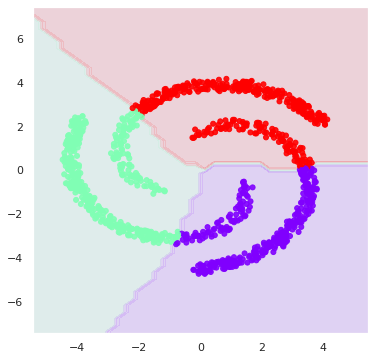

Epoch  31 (  31) | loss 0.420 | LR 0.0010 | beta 1.0000 | jac 0.34409311413764954
Epoch  32 (  32) | loss 0.410 | LR 0.0010 | beta 1.0000 | jac 0.35925278067588806
Epoch  33 (  33) | loss 0.406 | LR 0.0010 | beta 1.0000 | jac 0.33685633540153503
Epoch  34 (  34) | loss 0.410 | LR 0.0010 | beta 1.0000 | jac 0.3370071351528168
Epoch  35 (  35) | loss 0.415 | LR 0.0010 | beta 1.0000 | jac 0.3298162519931793
Epoch  36 (  36) | loss 0.417 | LR 0.0010 | beta 1.0000 | jac 0.3405051827430725
Epoch  37 (  37) | loss 0.420 | LR 0.0010 | beta 1.0000 | jac 0.33798274397850037
Epoch  38 (  38) | loss 0.423 | LR 0.0010 | beta 1.0000 | jac 0.3380211591720581
Epoch  39 (  39) | loss 0.423 | LR 0.0010 | beta 1.0000 | jac 0.3349998891353607
Epoch  40 (  40) | loss 0.424 | LR 0.0010 | beta 1.0000 | jac 0.31816545128822327


<Figure size 360x216 with 0 Axes>

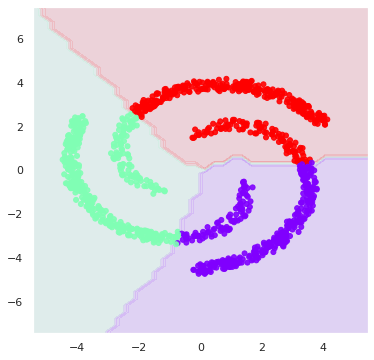

Epoch  41 (  41) | loss 0.422 | LR 0.0010 | beta 1.0000 | jac 0.31126296520233154
Epoch  42 (  42) | loss 0.416 | LR 0.0010 | beta 1.0000 | jac 0.32375773787498474
Epoch  43 (  43) | loss 0.406 | LR 0.0010 | beta 1.0000 | jac 0.3406583070755005
Epoch  44 (  44) | loss 0.397 | LR 0.0010 | beta 1.0000 | jac 0.33596280217170715
Epoch  45 (  45) | loss 0.393 | LR 0.0010 | beta 1.0000 | jac 0.3413277268409729
Epoch  46 (  46) | loss 0.394 | LR 0.0010 | beta 1.0000 | jac 0.33104804158210754
Epoch  47 (  47) | loss 0.399 | LR 0.0010 | beta 1.0000 | jac 0.3090580701828003
Epoch  48 (  48) | loss 0.403 | LR 0.0010 | beta 1.0000 | jac 0.31023454666137695
Epoch  49 (  49) | loss 0.401 | LR 0.0010 | beta 1.0000 | jac 0.3146885931491852
Epoch  50 (  50) | loss 0.396 | LR 0.0010 | beta 1.0000 | jac 0.31169959902763367


<Figure size 360x216 with 0 Axes>

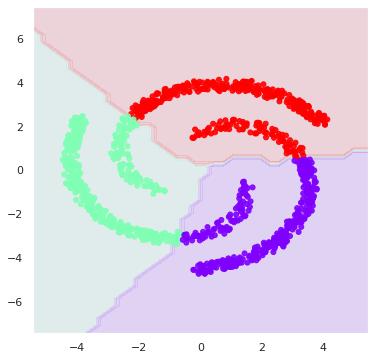

Epoch  51 (  51) | loss 0.385 | LR 0.0010 | beta 1.0000 | jac 0.36268508434295654
Epoch  52 (  52) | loss 0.371 | LR 0.0010 | beta 1.0000 | jac 0.3517642915248871
Epoch  53 (  53) | loss 0.365 | LR 0.0010 | beta 1.0000 | jac 0.35567325353622437
Epoch  54 (  54) | loss 0.368 | LR 0.0010 | beta 1.0000 | jac 0.32509714365005493
Epoch  55 (  55) | loss 0.376 | LR 0.0010 | beta 1.0000 | jac 0.30928507447242737
Epoch  56 (  56) | loss 0.381 | LR 0.0010 | beta 1.0000 | jac 0.3374375104904175
Epoch  57 (  57) | loss 0.378 | LR 0.0010 | beta 1.0000 | jac 0.3566550612449646
Epoch  58 (  58) | loss 0.380 | LR 0.0010 | beta 1.0000 | jac 0.33086004853248596
Epoch  59 (  59) | loss 0.387 | LR 0.0010 | beta 1.0000 | jac 0.31649720668792725
Epoch  60 (  60) | loss 0.392 | LR 0.0010 | beta 1.0000 | jac 0.32493361830711365


<Figure size 360x216 with 0 Axes>

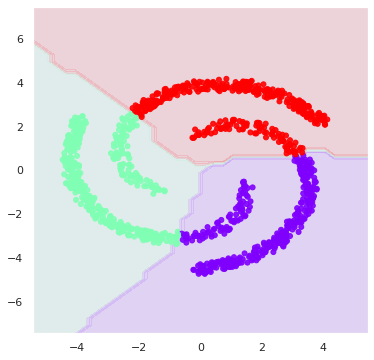

Epoch  61 (  61) | loss 0.390 | LR 0.0010 | beta 1.0000 | jac 0.33970776200294495
Epoch  62 (  62) | loss 0.389 | LR 0.0010 | beta 1.0000 | jac 0.33072954416275024
Epoch  63 (  63) | loss 0.394 | LR 0.0010 | beta 1.0000 | jac 0.3068316578865051
Epoch  64 (  64) | loss 0.398 | LR 0.0010 | beta 1.0000 | jac 0.3140026032924652
Epoch  65 (  65) | loss 0.397 | LR 0.0010 | beta 1.0000 | jac 0.2864065170288086
Epoch  66 (  66) | loss 0.400 | LR 0.0010 | beta 1.0000 | jac 0.26619648933410645
Epoch  67 (  67) | loss 0.399 | LR 0.0010 | beta 1.0000 | jac 0.30888211727142334
Epoch  68 (  68) | loss 0.389 | LR 0.0010 | beta 1.0000 | jac 0.31177935004234314
Epoch  69 (  69) | loss 0.377 | LR 0.0010 | beta 1.0000 | jac 0.3149779438972473
Epoch  70 (  70) | loss 0.369 | LR 0.0010 | beta 1.0000 | jac 0.27654847502708435


<Figure size 360x216 with 0 Axes>

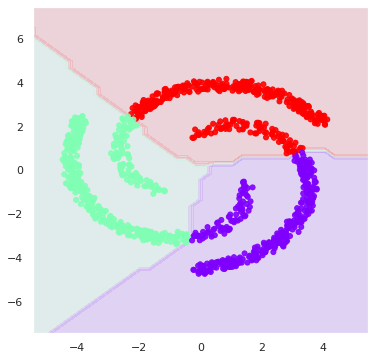

Epoch  71 (  71) | loss 0.367 | LR 0.0010 | beta 1.0000 | jac 0.3014276623725891
Epoch  72 (  72) | loss 0.359 | LR 0.0010 | beta 1.0000 | jac 0.3096295893192291
Epoch  73 (  73) | loss 0.348 | LR 0.0010 | beta 1.0000 | jac 0.28785955905914307
Epoch  74 (  74) | loss 0.341 | LR 0.0010 | beta 1.0000 | jac 0.31111055612564087
Epoch  75 (  75) | loss 0.340 | LR 0.0010 | beta 1.0000 | jac 0.29472920298576355
Epoch  76 (  76) | loss 0.339 | LR 0.0010 | beta 1.0000 | jac 0.29431116580963135
Epoch  77 (  77) | loss 0.334 | LR 0.0010 | beta 1.0000 | jac 0.28434938192367554
Epoch  78 (  78) | loss 0.330 | LR 0.0010 | beta 1.0000 | jac 0.30024445056915283
Epoch  79 (  79) | loss 0.328 | LR 0.0010 | beta 1.0000 | jac 0.29452699422836304
Epoch  80 (  80) | loss 0.332 | LR 0.0010 | beta 1.0000 | jac 0.2748168706893921


<Figure size 360x216 with 0 Axes>

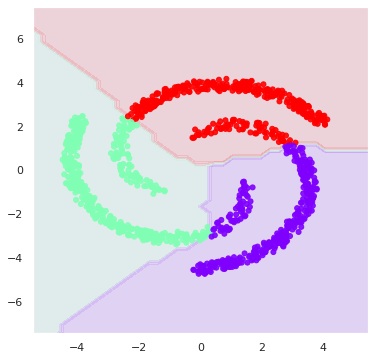

Epoch  81 (  81) | loss 0.339 | LR 0.0010 | beta 1.0000 | jac 0.29078924655914307
Epoch  82 (  82) | loss 0.342 | LR 0.0010 | beta 1.0000 | jac 0.2640177607536316
Epoch  83 (  83) | loss 0.340 | LR 0.0010 | beta 1.0000 | jac 0.311570405960083
Epoch  84 (  84) | loss 0.331 | LR 0.0010 | beta 1.0000 | jac 0.2967555522918701
Epoch  85 (  85) | loss 0.335 | LR 0.0010 | beta 1.0000 | jac 0.2810373604297638
Epoch  86 (  86) | loss 0.341 | LR 0.0010 | beta 1.0000 | jac 0.3059864044189453
Epoch  87 (  87) | loss 0.347 | LR 0.0010 | beta 1.0000 | jac 0.2737272083759308
Epoch  88 (  88) | loss 0.359 | LR 0.0010 | beta 1.0000 | jac 0.24776174128055573
Epoch  89 (  89) | loss 0.370 | LR 0.0010 | beta 1.0000 | jac 0.23830445110797882
Epoch  90 (  90) | loss 0.368 | LR 0.0010 | beta 1.0000 | jac 0.27807095646858215


<Figure size 360x216 with 0 Axes>

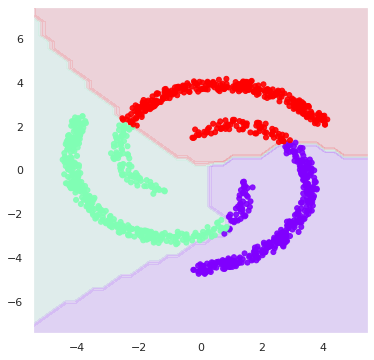

Epoch  91 (  91) | loss 0.356 | LR 0.0010 | beta 1.0000 | jac 0.2733386158943176
Epoch  92 (  92) | loss 0.348 | LR 0.0010 | beta 1.0000 | jac 0.2677801847457886
Epoch  93 (  93) | loss 0.339 | LR 0.0010 | beta 1.0000 | jac 0.2824935019016266
Epoch  94 (  94) | loss 0.339 | LR 0.0010 | beta 1.0000 | jac 0.25631144642829895
Epoch  95 (  95) | loss 0.345 | LR 0.0010 | beta 1.0000 | jac 0.2977350056171417
Epoch  96 (  96) | loss 0.336 | LR 0.0010 | beta 1.0000 | jac 0.31222423911094666
Epoch  97 (  97) | loss 0.328 | LR 0.0010 | beta 1.0000 | jac 0.3176780343055725
Epoch  98 (  98) | loss 0.329 | LR 0.0010 | beta 1.0000 | jac 0.2696387767791748
Epoch  99 (  99) | loss 0.358 | LR 0.0010 | beta 1.0000 | jac 0.23556984961032867
Epoch 100 ( 100) | loss 0.376 | LR 0.0010 | beta 1.0000 | jac 0.2664623260498047


<Figure size 360x216 with 0 Axes>

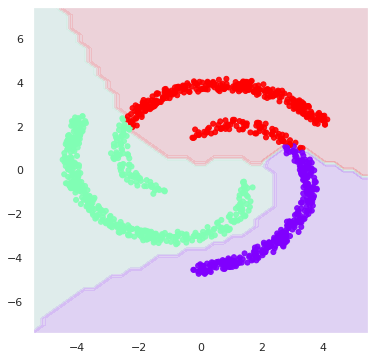

Epoch 101 ( 101) | loss 0.359 | LR 0.0010 | beta 1.0000 | jac 0.3073607385158539
Epoch 102 ( 102) | loss 0.339 | LR 0.0010 | beta 1.0000 | jac 0.24704691767692566
Epoch 103 ( 103) | loss 0.328 | LR 0.0010 | beta 1.0000 | jac 0.2830563485622406
Epoch 104 ( 104) | loss 0.318 | LR 0.0010 | beta 1.0000 | jac 0.25098085403442383
Epoch 105 ( 105) | loss 0.316 | LR 0.0010 | beta 1.0000 | jac 0.21473297476768494
Epoch 106 ( 106) | loss 0.308 | LR 0.0010 | beta 1.0000 | jac 0.24449661374092102
Epoch 107 ( 107) | loss 0.294 | LR 0.0010 | beta 1.0000 | jac 0.22792328894138336
Epoch 108 ( 108) | loss 0.276 | LR 0.0010 | beta 1.0000 | jac 0.21621134877204895
Epoch 109 ( 109) | loss 0.260 | LR 0.0010 | beta 1.0000 | jac 0.21763549745082855
Epoch 110 ( 110) | loss 0.248 | LR 0.0010 | beta 1.0000 | jac 0.2324109673500061


<Figure size 360x216 with 0 Axes>

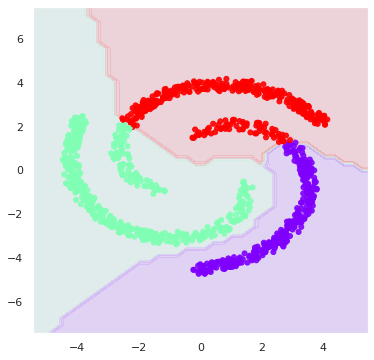

Epoch 111 ( 111) | loss 0.240 | LR 0.0010 | beta 1.0000 | jac 0.23418903350830078
Epoch 112 ( 112) | loss 0.239 | LR 0.0010 | beta 1.0000 | jac 0.22088168561458588
Epoch 113 ( 113) | loss 0.238 | LR 0.0010 | beta 1.0000 | jac 0.21835848689079285
Epoch 114 ( 114) | loss 0.240 | LR 0.0010 | beta 1.0000 | jac 0.21906006336212158
Epoch 115 ( 115) | loss 0.240 | LR 0.0010 | beta 1.0000 | jac 0.25415411591529846
Epoch 116 ( 116) | loss 0.244 | LR 0.0010 | beta 1.0000 | jac 0.24423854053020477
Epoch 117 ( 117) | loss 0.248 | LR 0.0010 | beta 1.0000 | jac 0.2179877758026123
Epoch 118 ( 118) | loss 0.252 | LR 0.0010 | beta 1.0000 | jac 0.26234138011932373
Epoch 119 ( 119) | loss 0.248 | LR 0.0010 | beta 1.0000 | jac 0.20629188418388367
Epoch 120 ( 120) | loss 0.247 | LR 0.0010 | beta 1.0000 | jac 0.239140123128891


<Figure size 360x216 with 0 Axes>

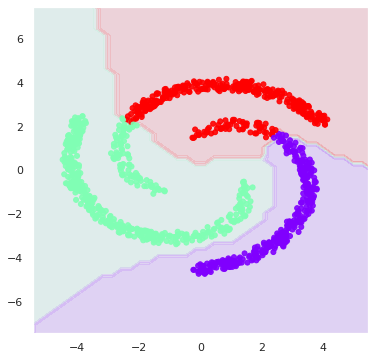

Epoch 121 ( 121) | loss 0.241 | LR 0.0010 | beta 1.0000 | jac 0.22417481243610382
Epoch 122 ( 122) | loss 0.235 | LR 0.0010 | beta 1.0000 | jac 0.20870918035507202
Epoch 123 ( 123) | loss 0.240 | LR 0.0010 | beta 1.0000 | jac 0.2214335948228836
Epoch 124 ( 124) | loss 0.248 | LR 0.0010 | beta 1.0000 | jac 0.21161283552646637
Epoch 125 ( 125) | loss 0.244 | LR 0.0010 | beta 1.0000 | jac 0.20878124237060547
Epoch 126 ( 126) | loss 0.234 | LR 0.0010 | beta 1.0000 | jac 0.21106719970703125
Epoch 127 ( 127) | loss 0.228 | LR 0.0010 | beta 1.0000 | jac 0.19255028665065765
Epoch 128 ( 128) | loss 0.228 | LR 0.0010 | beta 1.0000 | jac 0.20970776677131653
Epoch 129 ( 129) | loss 0.232 | LR 0.0010 | beta 1.0000 | jac 0.22559677064418793
Epoch 130 ( 130) | loss 0.232 | LR 0.0010 | beta 1.0000 | jac 0.31679561734199524


<Figure size 360x216 with 0 Axes>

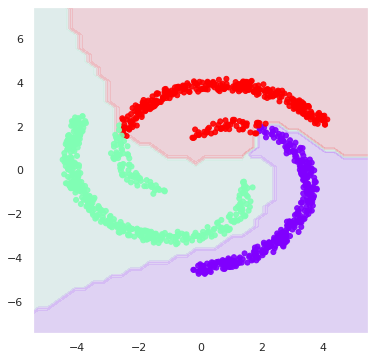

Epoch 131 ( 131) | loss 0.221 | LR 0.0010 | beta 1.0000 | jac 0.29414844512939453
Epoch 132 ( 132) | loss 0.222 | LR 0.0010 | beta 1.0000 | jac 0.26019346714019775
Epoch 133 ( 133) | loss 0.235 | LR 0.0010 | beta 1.0000 | jac 0.21424134075641632
Epoch 134 ( 134) | loss 0.247 | LR 0.0010 | beta 1.0000 | jac 0.2645699679851532
Epoch 135 ( 135) | loss 0.257 | LR 0.0010 | beta 1.0000 | jac 0.2440200299024582
Epoch 136 ( 136) | loss 0.268 | LR 0.0010 | beta 1.0000 | jac 0.21711347997188568
Epoch 137 ( 137) | loss 0.278 | LR 0.0010 | beta 1.0000 | jac 0.19083915650844574
Epoch 138 ( 138) | loss 0.278 | LR 0.0010 | beta 1.0000 | jac 0.17426298558712006
Epoch 139 ( 139) | loss 0.270 | LR 0.0010 | beta 1.0000 | jac 0.18298281729221344
Epoch 140 ( 140) | loss 0.264 | LR 0.0010 | beta 1.0000 | jac 0.20730653405189514


<Figure size 360x216 with 0 Axes>

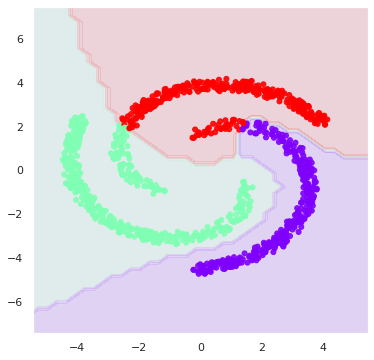

Epoch 141 ( 141) | loss 0.254 | LR 0.0010 | beta 1.0000 | jac 0.18241442739963531
Epoch 142 ( 142) | loss 0.243 | LR 0.0010 | beta 1.0000 | jac 0.20659129321575165
Epoch 143 ( 143) | loss 0.237 | LR 0.0010 | beta 1.0000 | jac 0.1804528832435608
Epoch 144 ( 144) | loss 0.235 | LR 0.0010 | beta 1.0000 | jac 0.24393250048160553
Epoch 145 ( 145) | loss 0.233 | LR 0.0010 | beta 1.0000 | jac 0.1677260845899582
Epoch 146 ( 146) | loss 0.229 | LR 0.0010 | beta 1.0000 | jac 0.18109086155891418
Epoch 147 ( 147) | loss 0.221 | LR 0.0010 | beta 1.0000 | jac 0.14127592742443085
Epoch 148 ( 148) | loss 0.212 | LR 0.0010 | beta 1.0000 | jac 0.2529147267341614
Epoch 149 ( 149) | loss 0.200 | LR 0.0010 | beta 1.0000 | jac 0.13212357461452484
Epoch 150 ( 150) | loss 0.193 | LR 0.0010 | beta 1.0000 | jac 0.18773898482322693


<Figure size 360x216 with 0 Axes>

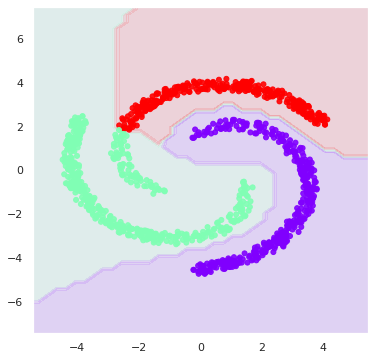

Epoch 151 ( 151) | loss 0.186 | LR 0.0010 | beta 1.0000 | jac 0.2202344834804535
Epoch 152 ( 152) | loss 0.180 | LR 0.0010 | beta 1.0000 | jac 0.18631769716739655
Epoch 153 ( 153) | loss 0.176 | LR 0.0010 | beta 1.0000 | jac 0.1911645233631134
Epoch 154 ( 154) | loss 0.173 | LR 0.0010 | beta 1.0000 | jac 0.18061095476150513
Epoch 155 ( 155) | loss 0.167 | LR 0.0010 | beta 1.0000 | jac 0.1925920993089676
Epoch 156 ( 156) | loss 0.162 | LR 0.0010 | beta 1.0000 | jac 0.2007683664560318
Epoch 157 ( 157) | loss 0.166 | LR 0.0010 | beta 1.0000 | jac 0.17229512333869934
Epoch 158 ( 158) | loss 0.169 | LR 0.0010 | beta 1.0000 | jac 0.16631940007209778
Epoch 159 ( 159) | loss 0.166 | LR 0.0010 | beta 1.0000 | jac 0.1607428789138794
Epoch 160 ( 160) | loss 0.161 | LR 0.0010 | beta 1.0000 | jac 0.12665146589279175


<Figure size 360x216 with 0 Axes>

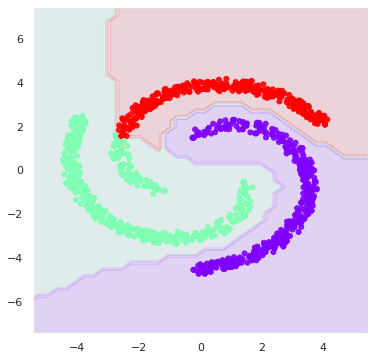

Epoch 161 ( 161) | loss 0.157 | LR 0.0010 | beta 1.0000 | jac 0.12379173934459686
Epoch 162 ( 162) | loss 0.152 | LR 0.0010 | beta 1.0000 | jac 0.11820068955421448
Epoch 163 ( 163) | loss 0.148 | LR 0.0010 | beta 1.0000 | jac 0.11171520501375198
Epoch 164 ( 164) | loss 0.142 | LR 0.0010 | beta 1.0000 | jac 0.11889474838972092
Epoch 165 ( 165) | loss 0.135 | LR 0.0010 | beta 1.0000 | jac 0.11558861285448074
Epoch 166 ( 166) | loss 0.129 | LR 0.0010 | beta 1.0000 | jac 0.1190723180770874
Epoch 167 ( 167) | loss 0.126 | LR 0.0010 | beta 1.0000 | jac 0.12946563959121704
Epoch 168 ( 168) | loss 0.121 | LR 0.0010 | beta 1.0000 | jac 0.13104891777038574
Epoch 169 ( 169) | loss 0.117 | LR 0.0010 | beta 1.0000 | jac 0.1159139946103096
Epoch 170 ( 170) | loss 0.117 | LR 0.0010 | beta 1.0000 | jac 0.11738540977239609


<Figure size 360x216 with 0 Axes>

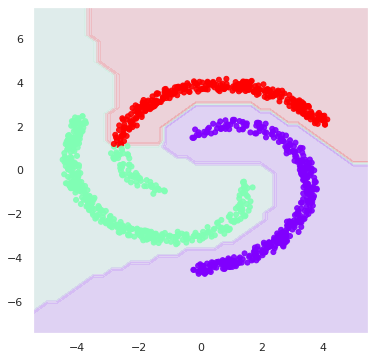

Epoch 171 ( 171) | loss 0.116 | LR 0.0010 | beta 1.0000 | jac 0.131605327129364
Epoch 172 ( 172) | loss 0.118 | LR 0.0010 | beta 1.0000 | jac 0.1631530374288559
Epoch 173 ( 173) | loss 0.123 | LR 0.0010 | beta 1.0000 | jac 0.13171854615211487
Epoch 174 ( 174) | loss 0.130 | LR 0.0010 | beta 1.0000 | jac 0.12400434166193008
Epoch 175 ( 175) | loss 0.126 | LR 0.0010 | beta 1.0000 | jac 0.11879061907529831
Epoch 176 ( 176) | loss 0.122 | LR 0.0010 | beta 1.0000 | jac 0.1411619335412979
Epoch 177 ( 177) | loss 0.117 | LR 0.0010 | beta 1.0000 | jac 0.12962496280670166
Epoch 178 ( 178) | loss 0.116 | LR 0.0010 | beta 1.0000 | jac 0.1584436595439911
Epoch 179 ( 179) | loss 0.115 | LR 0.0010 | beta 1.0000 | jac 0.12293098866939545
Epoch 180 ( 180) | loss 0.123 | LR 0.0010 | beta 1.0000 | jac 0.1103152483701706


<Figure size 360x216 with 0 Axes>

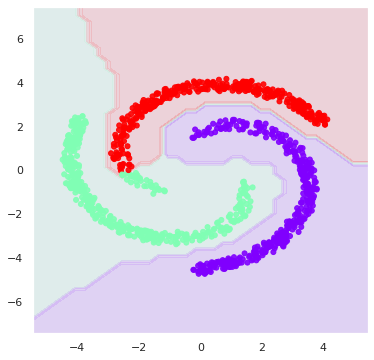

Epoch 181 ( 181) | loss 0.127 | LR 0.0010 | beta 1.0000 | jac 0.1240633949637413
Epoch 182 ( 182) | loss 0.122 | LR 0.0010 | beta 1.0000 | jac 0.12799698114395142
Epoch 183 ( 183) | loss 0.112 | LR 0.0010 | beta 1.0000 | jac 0.1117401272058487
Epoch 184 ( 184) | loss 0.105 | LR 0.0010 | beta 1.0000 | jac 0.11194539815187454
Epoch 185 ( 185) | loss 0.104 | LR 0.0010 | beta 1.0000 | jac 0.2245834469795227
Epoch 186 ( 186) | loss 0.103 | LR 0.0010 | beta 1.0000 | jac 0.11048337817192078
Epoch 187 ( 187) | loss 0.116 | LR 0.0010 | beta 1.0000 | jac 0.11933543533086777
Epoch 188 ( 188) | loss 0.121 | LR 0.0010 | beta 1.0000 | jac 0.09720661491155624
Epoch 189 ( 189) | loss 0.118 | LR 0.0010 | beta 1.0000 | jac 0.09016480296850204
Epoch 190 ( 190) | loss 0.112 | LR 0.0010 | beta 1.0000 | jac 0.09347248077392578


<Figure size 360x216 with 0 Axes>

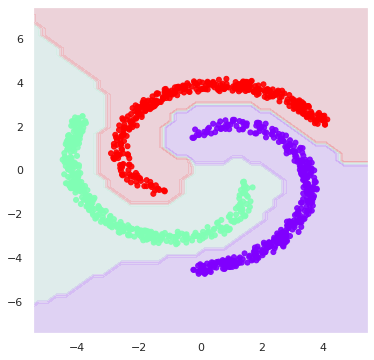

Epoch 191 ( 191) | loss 0.105 | LR 0.0010 | beta 1.0000 | jac 0.11016698181629181
Epoch 192 ( 192) | loss 0.092 | LR 0.0010 | beta 1.0000 | jac 0.15675605833530426
Epoch 193 ( 193) | loss 0.086 | LR 0.0010 | beta 1.0000 | jac 0.09200958162546158
Epoch 194 ( 194) | loss 0.101 | LR 0.0010 | beta 1.0000 | jac 0.09899680316448212
Epoch 195 ( 195) | loss 0.090 | LR 0.0010 | beta 1.0000 | jac 0.0641009509563446
Epoch 196 ( 196) | loss 0.075 | LR 0.0010 | beta 1.0000 | jac 0.09133335202932358
Epoch 197 ( 197) | loss 0.067 | LR 0.0010 | beta 1.0000 | jac 0.060604289174079895
Epoch 198 ( 198) | loss 0.065 | LR 0.0010 | beta 1.0000 | jac 0.07441873103380203
Epoch 199 ( 199) | loss 0.060 | LR 0.0010 | beta 1.0000 | jac 0.10452795773744583
Epoch 200 ( 200) | loss 0.055 | LR 0.0010 | beta 1.0000 | jac 0.07884776592254639


<Figure size 360x216 with 0 Axes>

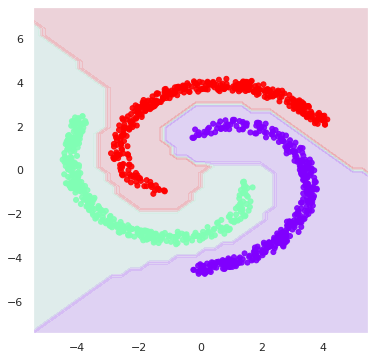

Epoch 201 ( 201) | loss 0.058 | LR 0.0010 | beta 1.0000 | jac 0.08299069851636887
Epoch 202 ( 202) | loss 0.056 | LR 0.0010 | beta 1.0000 | jac 0.11339696496725082
Epoch 203 ( 203) | loss 0.054 | LR 0.0010 | beta 1.0000 | jac 0.0915503278374672
Epoch 204 ( 204) | loss 0.053 | LR 0.0010 | beta 1.0000 | jac 0.0698266252875328
Epoch 205 ( 205) | loss 0.051 | LR 0.0010 | beta 1.0000 | jac 0.07302476465702057
Epoch 206 ( 206) | loss 0.047 | LR 0.0010 | beta 1.0000 | jac 0.0824906975030899
Epoch 207 ( 207) | loss 0.044 | LR 0.0010 | beta 1.0000 | jac 0.05629977211356163
Epoch 208 ( 208) | loss 0.043 | LR 0.0010 | beta 1.0000 | jac 0.0763455256819725
Epoch 209 ( 209) | loss 0.041 | LR 0.0010 | beta 1.0000 | jac 0.10473758727312088
Epoch 210 ( 210) | loss 0.040 | LR 0.0010 | beta 1.0000 | jac 0.08621492236852646


<Figure size 360x216 with 0 Axes>

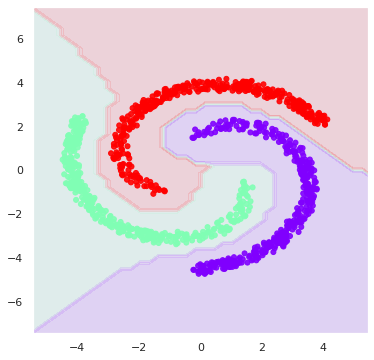

Epoch 211 ( 211) | loss 0.045 | LR 0.0010 | beta 1.0000 | jac 0.08674810081720352
Epoch 212 ( 212) | loss 0.048 | LR 0.0010 | beta 1.0000 | jac 0.07959901541471481
Epoch 213 ( 213) | loss 0.045 | LR 0.0010 | beta 1.0000 | jac 0.09076013416051865
Epoch 214 ( 214) | loss 0.041 | LR 0.0010 | beta 1.0000 | jac 0.11285705864429474
Epoch 215 ( 215) | loss 0.042 | LR 0.0010 | beta 1.0000 | jac 0.08709047734737396
Epoch 216 ( 216) | loss 0.041 | LR 0.0010 | beta 1.0000 | jac 0.09251799434423447
Epoch 217 ( 217) | loss 0.041 | LR 0.0010 | beta 1.0000 | jac 0.100893035531044
Epoch 218 ( 218) | loss 0.046 | LR 0.0010 | beta 1.0000 | jac 0.07329891622066498
Epoch 219 ( 219) | loss 0.054 | LR 0.0010 | beta 1.0000 | jac 0.06046305596828461
Epoch 220 ( 220) | loss 0.050 | LR 0.0010 | beta 1.0000 | jac 0.08290421962738037


<Figure size 360x216 with 0 Axes>

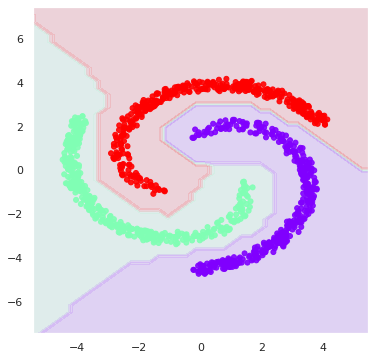

Epoch 221 ( 221) | loss 0.043 | LR 0.0010 | beta 1.0000 | jac 0.08322031050920486
Epoch 222 ( 222) | loss 0.040 | LR 0.0010 | beta 1.0000 | jac 0.0647515282034874
Epoch 223 ( 223) | loss 0.040 | LR 0.0010 | beta 1.0000 | jac 0.05872107297182083
Epoch 224 ( 224) | loss 0.040 | LR 0.0010 | beta 1.0000 | jac 0.05540487915277481
Epoch 225 ( 225) | loss 0.039 | LR 0.0010 | beta 1.0000 | jac 0.0548819936811924
Epoch 226 ( 226) | loss 0.036 | LR 0.0010 | beta 1.0000 | jac 0.05578329786658287
Epoch 227 ( 227) | loss 0.034 | LR 0.0010 | beta 1.0000 | jac 0.058234114199876785
Epoch 228 ( 228) | loss 0.034 | LR 0.0010 | beta 1.0000 | jac 0.05373341962695122
Epoch 229 ( 229) | loss 0.031 | LR 0.0010 | beta 1.0000 | jac 0.04980982095003128
Epoch 230 ( 230) | loss 0.029 | LR 0.0010 | beta 1.0000 | jac 0.04436827823519707


<Figure size 360x216 with 0 Axes>

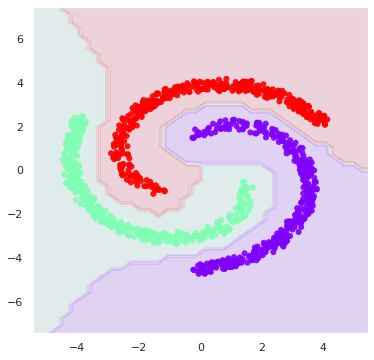

Epoch 231 ( 231) | loss 0.027 | LR 0.0010 | beta 1.0000 | jac 0.041815344244241714
Epoch 232 ( 232) | loss 0.026 | LR 0.0010 | beta 1.0000 | jac 0.03555187210440636
Epoch 233 ( 233) | loss 0.025 | LR 0.0010 | beta 1.0000 | jac 0.03523082286119461
Epoch 234 ( 234) | loss 0.024 | LR 0.0010 | beta 1.0000 | jac 0.03318848833441734
Epoch 235 ( 235) | loss 0.022 | LR 0.0010 | beta 1.0000 | jac 0.03453528881072998
Epoch 236 ( 236) | loss 0.020 | LR 0.0010 | beta 1.0000 | jac 0.0941087156534195
Epoch 237 ( 237) | loss 0.019 | LR 0.0010 | beta 1.0000 | jac 0.055101580917835236
Epoch 238 ( 238) | loss 0.020 | LR 0.0010 | beta 1.0000 | jac 0.04705018177628517
Epoch 239 ( 239) | loss 0.020 | LR 0.0010 | beta 1.0000 | jac 0.03323153778910637
Epoch 240 ( 240) | loss 0.019 | LR 0.0010 | beta 1.0000 | jac 0.04576299339532852


<Figure size 360x216 with 0 Axes>

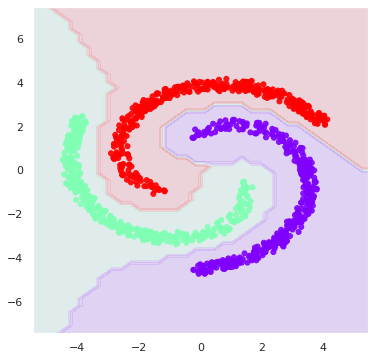

Epoch 241 ( 241) | loss 0.019 | LR 0.0010 | beta 1.0000 | jac 0.03969612345099449
Epoch 242 ( 242) | loss 0.019 | LR 0.0010 | beta 1.0000 | jac 0.04344652220606804
Epoch 243 ( 243) | loss 0.019 | LR 0.0010 | beta 1.0000 | jac 0.03402876481413841
Epoch 244 ( 244) | loss 0.019 | LR 0.0010 | beta 1.0000 | jac 0.03317863866686821
Epoch 245 ( 245) | loss 0.018 | LR 0.0010 | beta 1.0000 | jac 0.04656737297773361
Epoch 246 ( 246) | loss 0.017 | LR 0.0010 | beta 1.0000 | jac 0.03343422710895538
Epoch 247 ( 247) | loss 0.017 | LR 0.0010 | beta 1.0000 | jac 0.03059162199497223
Epoch 248 ( 248) | loss 0.017 | LR 0.0010 | beta 1.0000 | jac 0.030835183337330818
Epoch 249 ( 249) | loss 0.017 | LR 0.0010 | beta 1.0000 | jac 0.031685538589954376
Epoch 250 ( 250) | loss 0.017 | LR 0.0010 | beta 1.0000 | jac 0.03099881485104561


<Figure size 360x216 with 0 Axes>

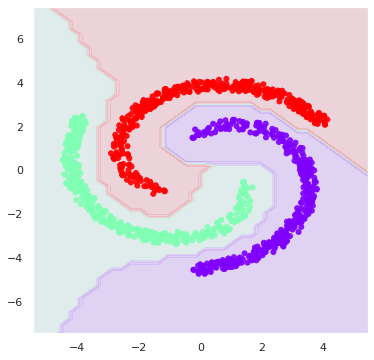

Epoch 251 ( 251) | loss 0.017 | LR 0.0010 | beta 1.0000 | jac 0.045980826020240784
Epoch 252 ( 252) | loss 0.016 | LR 0.0010 | beta 1.0000 | jac 0.02919946052134037
Epoch 253 ( 253) | loss 0.016 | LR 0.0010 | beta 1.0000 | jac 0.02736721746623516
Epoch 254 ( 254) | loss 0.015 | LR 0.0010 | beta 1.0000 | jac 0.04594014957547188
Epoch 255 ( 255) | loss 0.015 | LR 0.0010 | beta 1.0000 | jac 0.03694114089012146
Epoch 256 ( 256) | loss 0.014 | LR 0.0010 | beta 1.0000 | jac 0.025776298716664314
Epoch 257 ( 257) | loss 0.014 | LR 0.0010 | beta 1.0000 | jac 0.028059756383299828
Epoch 258 ( 258) | loss 0.014 | LR 0.0010 | beta 1.0000 | jac 0.023036103695631027
Epoch 259 ( 259) | loss 0.014 | LR 0.0010 | beta 1.0000 | jac 0.04851445183157921
Epoch 260 ( 260) | loss 0.013 | LR 0.0010 | beta 1.0000 | jac 0.019505109637975693


<Figure size 360x216 with 0 Axes>

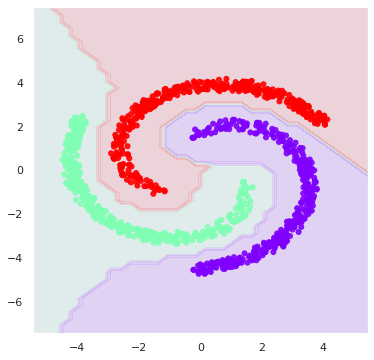

Epoch 261 ( 261) | loss 0.013 | LR 0.0010 | beta 1.0000 | jac 0.020927902311086655
Epoch 262 ( 262) | loss 0.013 | LR 0.0010 | beta 1.0000 | jac 0.02216237410902977
Epoch 263 ( 263) | loss 0.012 | LR 0.0010 | beta 1.0000 | jac 0.019575610756874084
Epoch 264 ( 264) | loss 0.012 | LR 0.0010 | beta 1.0000 | jac 0.09754297137260437
Epoch 265 ( 265) | loss 0.011 | LR 0.0010 | beta 1.0000 | jac 0.03889395669102669
Epoch 266 ( 266) | loss 0.012 | LR 0.0010 | beta 1.0000 | jac 0.056994158774614334
Epoch 267 ( 267) | loss 0.012 | LR 0.0010 | beta 1.0000 | jac 0.05845502391457558
Epoch 268 ( 268) | loss 0.013 | LR 0.0010 | beta 1.0000 | jac 0.037654679268598557
Epoch 269 ( 269) | loss 0.013 | LR 0.0010 | beta 1.0000 | jac 0.03794153779745102
Epoch 270 ( 270) | loss 0.014 | LR 0.0010 | beta 1.0000 | jac 0.035127341747283936


<Figure size 360x216 with 0 Axes>

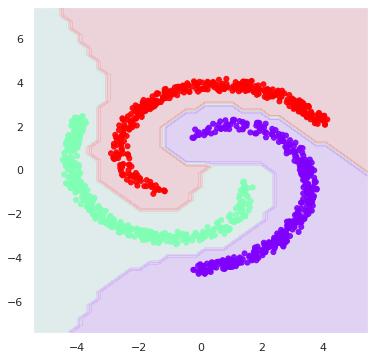

Epoch 271 ( 271) | loss 0.014 | LR 0.0010 | beta 1.0000 | jac 0.05954768508672714
Epoch 272 ( 272) | loss 0.014 | LR 0.0010 | beta 1.0000 | jac 0.041362959891557693
Epoch 273 ( 273) | loss 0.014 | LR 0.0010 | beta 1.0000 | jac 0.04202994704246521
Epoch 274 ( 274) | loss 0.014 | LR 0.0010 | beta 1.0000 | jac 0.05543215572834015
Epoch 275 ( 275) | loss 0.015 | LR 0.0010 | beta 1.0000 | jac 0.053817812353372574
Epoch 276 ( 276) | loss 0.016 | LR 0.0010 | beta 1.0000 | jac 0.038735151290893555
Epoch 277 ( 277) | loss 0.016 | LR 0.0010 | beta 1.0000 | jac 0.06022169813513756
Epoch 278 ( 278) | loss 0.015 | LR 0.0010 | beta 1.0000 | jac 0.03034188039600849
Epoch 279 ( 279) | loss 0.015 | LR 0.0010 | beta 1.0000 | jac 0.03644193708896637
Epoch 280 ( 280) | loss 0.016 | LR 0.0010 | beta 1.0000 | jac 0.03304733708500862


<Figure size 360x216 with 0 Axes>

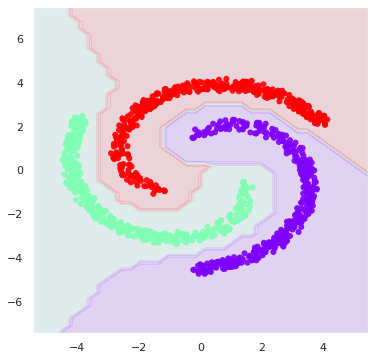

Epoch 281 ( 281) | loss 0.016 | LR 0.0010 | beta 1.0000 | jac 0.02753872238099575
Epoch 282 ( 282) | loss 0.016 | LR 0.0010 | beta 1.0000 | jac 0.026020320132374763
Epoch 283 ( 283) | loss 0.016 | LR 0.0010 | beta 1.0000 | jac 0.029819801449775696
Epoch 284 ( 284) | loss 0.016 | LR 0.0010 | beta 1.0000 | jac 0.026953767985105515
Epoch 285 ( 285) | loss 0.015 | LR 0.0010 | beta 1.0000 | jac 0.02691139280796051
Epoch 286 ( 286) | loss 0.015 | LR 0.0010 | beta 1.0000 | jac 0.0520487017929554
Epoch 287 ( 287) | loss 0.014 | LR 0.0010 | beta 1.0000 | jac 0.02626825124025345
Epoch 288 ( 288) | loss 0.014 | LR 0.0010 | beta 1.0000 | jac 0.02997901663184166
Epoch 289 ( 289) | loss 0.014 | LR 0.0010 | beta 1.0000 | jac 0.0393841452896595
Epoch 290 ( 290) | loss 0.014 | LR 0.0010 | beta 1.0000 | jac 0.036450501531362534


<Figure size 360x216 with 0 Axes>

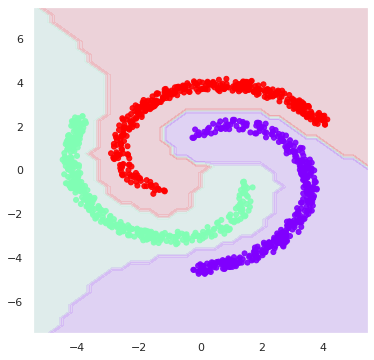

Epoch 291 ( 291) | loss 0.013 | LR 0.0010 | beta 1.0000 | jac 0.05168769508600235
Epoch 292 ( 292) | loss 0.013 | LR 0.0010 | beta 1.0000 | jac 0.06128358468413353
Epoch 293 ( 293) | loss 0.013 | LR 0.0010 | beta 1.0000 | jac 0.0656343474984169
Epoch 294 ( 294) | loss 0.013 | LR 0.0010 | beta 1.0000 | jac 0.07188095897436142
Epoch 295 ( 295) | loss 0.014 | LR 0.0010 | beta 1.0000 | jac 0.07093936949968338
Epoch 296 ( 296) | loss 0.014 | LR 0.0010 | beta 1.0000 | jac 0.06261395663022995
Epoch 297 ( 297) | loss 0.015 | LR 0.0010 | beta 1.0000 | jac 0.06791819632053375
Epoch 298 ( 298) | loss 0.016 | LR 0.0010 | beta 1.0000 | jac 0.06561469286680222
Epoch 299 ( 299) | loss 0.018 | LR 0.0010 | beta 1.0000 | jac 0.06905558705329895
Epoch 300 ( 300) | loss 0.019 | LR 0.0010 | beta 1.0000 | jac 0.04900062084197998


<Figure size 360x216 with 0 Axes>

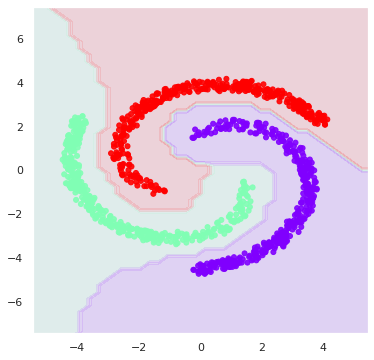

Epoch 301 ( 301) | loss 0.019 | LR 0.0010 | beta 1.0000 | jac 0.06580021232366562
Epoch 302 ( 302) | loss 0.019 | LR 0.0010 | beta 1.0000 | jac 0.04163059964776039
Epoch 303 ( 303) | loss 0.020 | LR 0.0010 | beta 1.0000 | jac 0.05919588729739189
Epoch 304 ( 304) | loss 0.020 | LR 0.0010 | beta 1.0000 | jac 0.0668376013636589
Epoch 305 ( 305) | loss 0.021 | LR 0.0010 | beta 1.0000 | jac 0.10716626793146133
Epoch 306 ( 306) | loss 0.022 | LR 0.0010 | beta 1.0000 | jac 0.07672998309135437
Epoch 307 ( 307) | loss 0.022 | LR 0.0010 | beta 1.0000 | jac 0.050606634467840195
Epoch 308 ( 308) | loss 0.025 | LR 0.0010 | beta 1.0000 | jac 0.3369607925415039
Epoch 309 ( 309) | loss 0.028 | LR 0.0010 | beta 1.0000 | jac 0.0932057574391365
Epoch 310 ( 310) | loss 0.031 | LR 0.0010 | beta 1.0000 | jac 1.319128394126892


<Figure size 360x216 with 0 Axes>

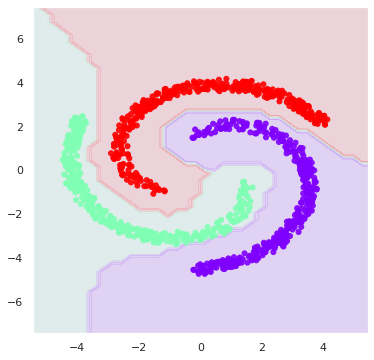

Epoch 311 ( 311) | loss 0.037 | LR 0.0010 | beta 1.0000 | jac 0.2532082796096802
Epoch 312 ( 312) | loss 0.095 | LR 0.0010 | beta 1.0000 | jac 1.7390226125717163
Epoch 313 ( 313) | loss 0.167 | LR 0.0010 | beta 1.0000 | jac 0.4469990134239197
Epoch 314 ( 314) | loss 0.226 | LR 0.0010 | beta 1.0000 | jac 1.0549484491348267
Epoch 315 ( 315) | loss 0.323 | LR 0.0010 | beta 1.0000 | jac 0.616334855556488
Epoch 316 ( 316) | loss 0.439 | LR 0.0010 | beta 1.0000 | jac 0.40482136607170105
Epoch 317 ( 317) | loss 0.553 | LR 0.0010 | beta 1.0000 | jac 0.43173614144325256
Epoch 318 ( 318) | loss 0.596 | LR 0.0010 | beta 1.0000 | jac 0.3118792772293091
Epoch 319 ( 319) | loss 0.587 | LR 0.0010 | beta 1.0000 | jac 0.26194337010383606
Epoch 320 ( 320) | loss 0.541 | LR 0.0010 | beta 1.0000 | jac 0.2724987864494324


<Figure size 360x216 with 0 Axes>

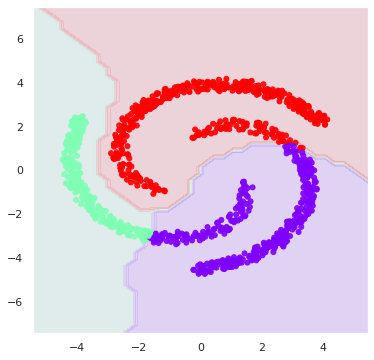

Epoch 321 ( 321) | loss 0.481 | LR 0.0010 | beta 1.0000 | jac 0.3263338506221771
Epoch 322 ( 322) | loss 0.427 | LR 0.0010 | beta 1.0000 | jac 0.3339789807796478
Epoch 323 ( 323) | loss 0.385 | LR 0.0010 | beta 1.0000 | jac 0.30538928508758545
Epoch 324 ( 324) | loss 0.354 | LR 0.0010 | beta 1.0000 | jac 0.33718419075012207
Epoch 325 ( 325) | loss 0.332 | LR 0.0010 | beta 1.0000 | jac 0.31542569398880005
Epoch 326 ( 326) | loss 0.320 | LR 0.0010 | beta 1.0000 | jac 0.2878979742527008
Epoch 327 ( 327) | loss 0.315 | LR 0.0010 | beta 1.0000 | jac 0.28904056549072266
Epoch 328 ( 328) | loss 0.310 | LR 0.0010 | beta 1.0000 | jac 0.281491756439209
Epoch 329 ( 329) | loss 0.304 | LR 0.0010 | beta 1.0000 | jac 0.2641098201274872
Epoch 330 ( 330) | loss 0.297 | LR 0.0010 | beta 1.0000 | jac 0.23780807852745056


<Figure size 360x216 with 0 Axes>

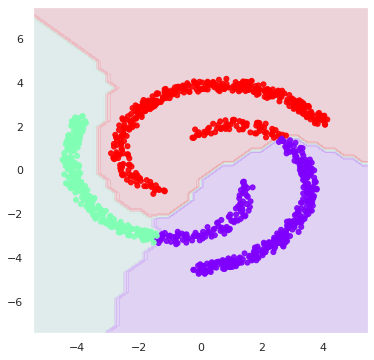

Epoch 331 ( 331) | loss 0.291 | LR 0.0010 | beta 1.0000 | jac 0.24078954756259918
Epoch 332 ( 332) | loss 0.284 | LR 0.0010 | beta 1.0000 | jac 0.27383512258529663
Epoch 333 ( 333) | loss 0.275 | LR 0.0010 | beta 1.0000 | jac 0.2734895944595337
Epoch 334 ( 334) | loss 0.267 | LR 0.0010 | beta 1.0000 | jac 0.26362285017967224
Epoch 335 ( 335) | loss 0.261 | LR 0.0010 | beta 1.0000 | jac 0.23947377502918243
Epoch 336 ( 336) | loss 0.257 | LR 0.0010 | beta 1.0000 | jac 0.24220754206180573
Epoch 337 ( 337) | loss 0.254 | LR 0.0010 | beta 1.0000 | jac 0.21280427277088165
Epoch 338 ( 338) | loss 0.252 | LR 0.0010 | beta 1.0000 | jac 0.2245061993598938
Epoch 339 ( 339) | loss 0.248 | LR 0.0010 | beta 1.0000 | jac 0.23068556189537048
Epoch 340 ( 340) | loss 0.241 | LR 0.0010 | beta 1.0000 | jac 0.21610060334205627


<Figure size 360x216 with 0 Axes>

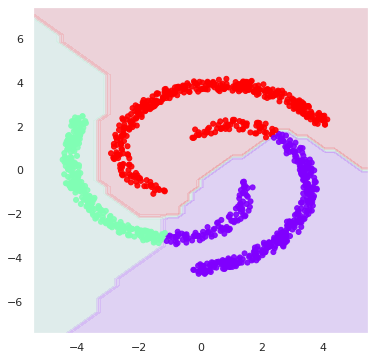

Epoch 341 ( 341) | loss 0.235 | LR 0.0010 | beta 1.0000 | jac 0.251714289188385
Epoch 342 ( 342) | loss 0.229 | LR 0.0010 | beta 1.0000 | jac 0.22510311007499695
Epoch 343 ( 343) | loss 0.227 | LR 0.0010 | beta 1.0000 | jac 0.24025574326515198
Epoch 344 ( 344) | loss 0.226 | LR 0.0010 | beta 1.0000 | jac 0.21769613027572632
Epoch 345 ( 345) | loss 0.229 | LR 0.0010 | beta 1.0000 | jac 0.19651085138320923
Epoch 346 ( 346) | loss 0.232 | LR 0.0010 | beta 1.0000 | jac 0.18999479711055756
Epoch 347 ( 347) | loss 0.234 | LR 0.0010 | beta 1.0000 | jac 0.19283124804496765
Epoch 348 ( 348) | loss 0.235 | LR 0.0010 | beta 1.0000 | jac 0.19225913286209106
Epoch 349 ( 349) | loss 0.234 | LR 0.0010 | beta 1.0000 | jac 0.1707363873720169
Epoch 350 ( 350) | loss 0.232 | LR 0.0010 | beta 1.0000 | jac 0.17618252336978912


<Figure size 360x216 with 0 Axes>

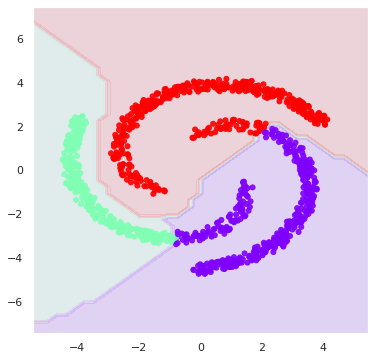

Epoch 351 ( 351) | loss 0.230 | LR 0.0010 | beta 1.0000 | jac 0.159433975815773
Epoch 352 ( 352) | loss 0.226 | LR 0.0010 | beta 1.0000 | jac 0.17788775265216827
Epoch 353 ( 353) | loss 0.223 | LR 0.0010 | beta 1.0000 | jac 0.16034722328186035
Epoch 354 ( 354) | loss 0.221 | LR 0.0010 | beta 1.0000 | jac 0.1601116806268692
Epoch 355 ( 355) | loss 0.218 | LR 0.0010 | beta 1.0000 | jac 0.16257482767105103
Epoch 356 ( 356) | loss 0.214 | LR 0.0010 | beta 1.0000 | jac 0.16600573062896729
Epoch 357 ( 357) | loss 0.210 | LR 0.0010 | beta 1.0000 | jac 0.1487138867378235
Epoch 358 ( 358) | loss 0.207 | LR 0.0010 | beta 1.0000 | jac 0.15233615040779114
Epoch 359 ( 359) | loss 0.204 | LR 0.0010 | beta 1.0000 | jac 0.174521341919899
Epoch 360 ( 360) | loss 0.201 | LR 0.0010 | beta 1.0000 | jac 0.12987498939037323


<Figure size 360x216 with 0 Axes>

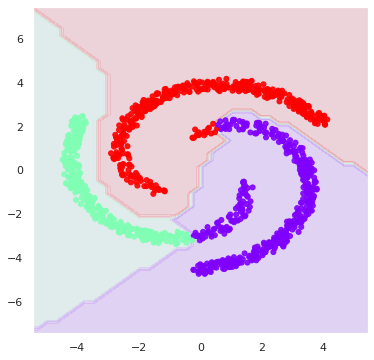

Epoch 361 ( 361) | loss 0.200 | LR 0.0010 | beta 1.0000 | jac 0.13939644396305084
Epoch 362 ( 362) | loss 0.198 | LR 0.0010 | beta 1.0000 | jac 0.1286366730928421
Epoch 363 ( 363) | loss 0.195 | LR 0.0010 | beta 1.0000 | jac 0.14784672856330872
Epoch 364 ( 364) | loss 0.190 | LR 0.0010 | beta 1.0000 | jac 0.11994298547506332
Epoch 365 ( 365) | loss 0.184 | LR 0.0010 | beta 1.0000 | jac 0.13131628930568695
Epoch 366 ( 366) | loss 0.178 | LR 0.0010 | beta 1.0000 | jac 0.12378237396478653
Epoch 367 ( 367) | loss 0.171 | LR 0.0010 | beta 1.0000 | jac 0.2139526605606079
Epoch 368 ( 368) | loss 0.164 | LR 0.0010 | beta 1.0000 | jac 0.10034666955471039
Epoch 369 ( 369) | loss 0.160 | LR 0.0010 | beta 1.0000 | jac 0.11736658960580826
Epoch 370 ( 370) | loss 0.154 | LR 0.0010 | beta 1.0000 | jac 0.10242834687232971


<Figure size 360x216 with 0 Axes>

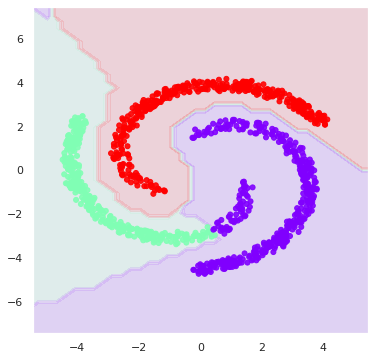

Epoch 371 ( 371) | loss 0.148 | LR 0.0010 | beta 1.0000 | jac 0.09650620073080063
Epoch 372 ( 372) | loss 0.143 | LR 0.0010 | beta 1.0000 | jac 0.08557752519845963
Epoch 373 ( 373) | loss 0.137 | LR 0.0010 | beta 1.0000 | jac 0.0944972112774849
Epoch 374 ( 374) | loss 0.132 | LR 0.0010 | beta 1.0000 | jac 0.10438334196805954
Epoch 375 ( 375) | loss 0.127 | LR 0.0010 | beta 1.0000 | jac 0.12222975492477417
Epoch 376 ( 376) | loss 0.122 | LR 0.0010 | beta 1.0000 | jac 0.0920737236738205
Epoch 377 ( 377) | loss 0.118 | LR 0.0010 | beta 1.0000 | jac 0.082997627556324
Epoch 378 ( 378) | loss 0.115 | LR 0.0010 | beta 1.0000 | jac 0.08891995996236801
Epoch 379 ( 379) | loss 0.112 | LR 0.0010 | beta 1.0000 | jac 0.08521432429552078
Epoch 380 ( 380) | loss 0.110 | LR 0.0010 | beta 1.0000 | jac 0.08214542269706726


<Figure size 360x216 with 0 Axes>

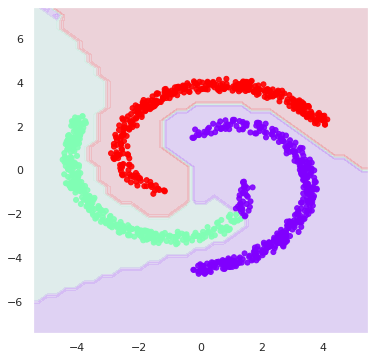

Epoch 381 ( 381) | loss 0.108 | LR 0.0010 | beta 1.0000 | jac 0.07581076771020889
Epoch 382 ( 382) | loss 0.105 | LR 0.0010 | beta 1.0000 | jac 0.08377263695001602
Epoch 383 ( 383) | loss 0.101 | LR 0.0010 | beta 1.0000 | jac 0.07424010336399078
Epoch 384 ( 384) | loss 0.096 | LR 0.0010 | beta 1.0000 | jac 0.06733694672584534
Epoch 385 ( 385) | loss 0.091 | LR 0.0010 | beta 1.0000 | jac 0.06724853813648224
Epoch 386 ( 386) | loss 0.085 | LR 0.0010 | beta 1.0000 | jac 0.0655478835105896
Epoch 387 ( 387) | loss 0.080 | LR 0.0010 | beta 1.0000 | jac 0.059139519929885864
Epoch 388 ( 388) | loss 0.074 | LR 0.0010 | beta 1.0000 | jac 0.05788908898830414
Epoch 389 ( 389) | loss 0.066 | LR 0.0010 | beta 1.0000 | jac 0.06252675503492355
Epoch 390 ( 390) | loss 0.059 | LR 0.0010 | beta 1.0000 | jac 0.07209117710590363


<Figure size 360x216 with 0 Axes>

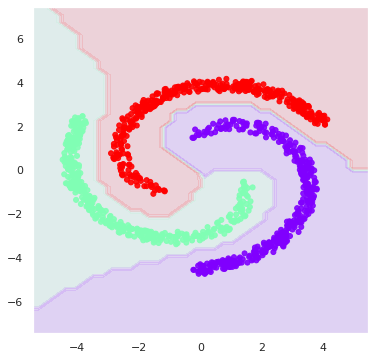

Epoch 391 ( 391) | loss 0.054 | LR 0.0010 | beta 1.0000 | jac 0.04551117867231369
Epoch 392 ( 392) | loss 0.050 | LR 0.0010 | beta 1.0000 | jac 0.05059945583343506
Epoch 393 ( 393) | loss 0.046 | LR 0.0010 | beta 1.0000 | jac 0.27032944560050964
Epoch 394 ( 394) | loss 0.044 | LR 0.0010 | beta 1.0000 | jac 0.05903635174036026
Epoch 395 ( 395) | loss 0.046 | LR 0.0010 | beta 1.0000 | jac 0.07474593073129654
Epoch 396 ( 396) | loss 0.049 | LR 0.0010 | beta 1.0000 | jac 0.10660586506128311
Epoch 397 ( 397) | loss 0.051 | LR 0.0010 | beta 1.0000 | jac 0.05045603960752487
Epoch 398 ( 398) | loss 0.051 | LR 0.0010 | beta 1.0000 | jac 0.0498870424926281
Epoch 399 ( 399) | loss 0.050 | LR 0.0010 | beta 1.0000 | jac 0.06067594140768051
Epoch 400 ( 400) | loss 0.050 | LR 0.0010 | beta 1.0000 | jac 0.04879670590162277


<Figure size 360x216 with 0 Axes>

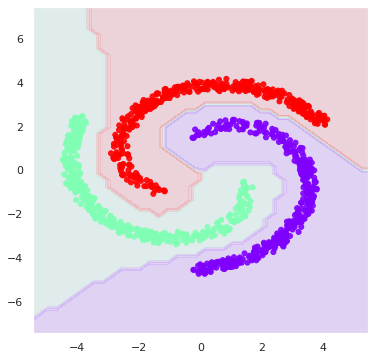

Epoch 401 ( 401) | loss 0.049 | LR 0.0010 | beta 1.0000 | jac 0.048157062381505966
Epoch 402 ( 402) | loss 0.047 | LR 0.0010 | beta 1.0000 | jac 0.0385516881942749
Epoch 403 ( 403) | loss 0.045 | LR 0.0010 | beta 1.0000 | jac 0.04178345575928688
Epoch 404 ( 404) | loss 0.043 | LR 0.0010 | beta 1.0000 | jac 0.040852952748537064
Epoch 405 ( 405) | loss 0.041 | LR 0.0010 | beta 1.0000 | jac 0.036662179976701736
Epoch 406 ( 406) | loss 0.038 | LR 0.0010 | beta 1.0000 | jac 0.04267102852463722
Epoch 407 ( 407) | loss 0.036 | LR 0.0010 | beta 1.0000 | jac 0.08367415517568588
Epoch 408 ( 408) | loss 0.034 | LR 0.0010 | beta 1.0000 | jac 0.0362236313521862
Epoch 409 ( 409) | loss 0.033 | LR 0.0010 | beta 1.0000 | jac 0.02856888435781002
Epoch 410 ( 410) | loss 0.032 | LR 0.0010 | beta 1.0000 | jac 0.028932219371199608


<Figure size 360x216 with 0 Axes>

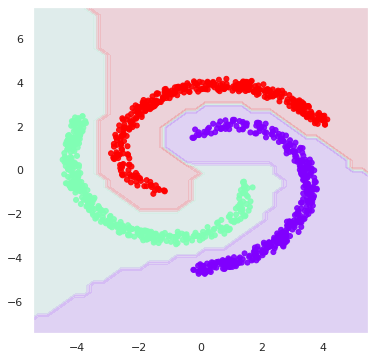

Epoch 411 ( 411) | loss 0.031 | LR 0.0010 | beta 1.0000 | jac 0.02973373420536518
Epoch 412 ( 412) | loss 0.030 | LR 0.0010 | beta 1.0000 | jac 0.02765282429754734
Epoch 413 ( 413) | loss 0.028 | LR 0.0010 | beta 1.0000 | jac 0.03080534003674984
Epoch 414 ( 414) | loss 0.027 | LR 0.0010 | beta 1.0000 | jac 0.06203509122133255
Epoch 415 ( 415) | loss 0.026 | LR 0.0010 | beta 1.0000 | jac 0.0267782025039196
Epoch 416 ( 416) | loss 0.025 | LR 0.0010 | beta 1.0000 | jac 0.026174945756793022
Epoch 417 ( 417) | loss 0.024 | LR 0.0010 | beta 1.0000 | jac 0.027581974864006042
Epoch 418 ( 418) | loss 0.023 | LR 0.0010 | beta 1.0000 | jac 0.029343757778406143
Epoch 419 ( 419) | loss 0.022 | LR 0.0010 | beta 1.0000 | jac 0.027786964550614357
Epoch 420 ( 420) | loss 0.020 | LR 0.0010 | beta 1.0000 | jac 0.034143876284360886


<Figure size 360x216 with 0 Axes>

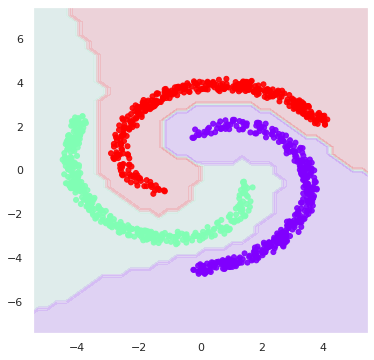

Epoch 421 ( 421) | loss 0.019 | LR 0.0010 | beta 1.0000 | jac 0.053726669400930405
Epoch 422 ( 422) | loss 0.019 | LR 0.0010 | beta 1.0000 | jac 0.04556634649634361
Epoch 423 ( 423) | loss 0.018 | LR 0.0010 | beta 1.0000 | jac 0.06020388379693031
Epoch 424 ( 424) | loss 0.019 | LR 0.0010 | beta 1.0000 | jac 0.08728440850973129
Epoch 425 ( 425) | loss 0.020 | LR 0.0010 | beta 1.0000 | jac 0.08849412202835083
Epoch 426 ( 426) | loss 0.023 | LR 0.0010 | beta 1.0000 | jac 0.08693113178014755
Epoch 427 ( 427) | loss 0.022 | LR 0.0010 | beta 1.0000 | jac 0.104782335460186
Epoch 428 ( 428) | loss 0.022 | LR 0.0010 | beta 1.0000 | jac 0.08214613795280457
Epoch 429 ( 429) | loss 0.023 | LR 0.0010 | beta 1.0000 | jac 0.10391756147146225
Epoch 430 ( 430) | loss 0.024 | LR 0.0010 | beta 1.0000 | jac 0.06642388552427292


<Figure size 360x216 with 0 Axes>

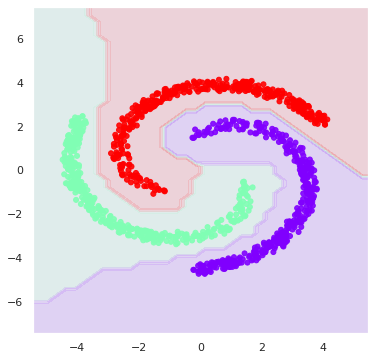

Epoch 431 ( 431) | loss 0.025 | LR 0.0010 | beta 1.0000 | jac 0.048054397106170654
Epoch 432 ( 432) | loss 0.025 | LR 0.0010 | beta 1.0000 | jac 0.05482263118028641
Epoch 433 ( 433) | loss 0.025 | LR 0.0010 | beta 1.0000 | jac 0.06580125540494919
Epoch 434 ( 434) | loss 0.026 | LR 0.0010 | beta 1.0000 | jac 0.04350164532661438
Epoch 435 ( 435) | loss 0.027 | LR 0.0010 | beta 1.0000 | jac 0.12642216682434082
Epoch 436 ( 436) | loss 0.028 | LR 0.0010 | beta 1.0000 | jac 0.05757974833250046
Epoch 437 ( 437) | loss 0.030 | LR 0.0010 | beta 1.0000 | jac 0.04655187577009201
Epoch 438 ( 438) | loss 0.030 | LR 0.0010 | beta 1.0000 | jac 0.039998579770326614
Epoch 439 ( 439) | loss 0.029 | LR 0.0010 | beta 1.0000 | jac 0.04194990172982216
Epoch 440 ( 440) | loss 0.029 | LR 0.0010 | beta 1.0000 | jac 0.038842570036649704


<Figure size 360x216 with 0 Axes>

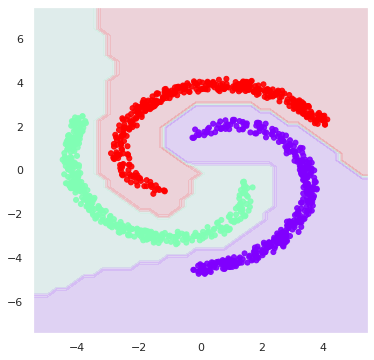

Epoch 441 ( 441) | loss 0.029 | LR 0.0010 | beta 1.0000 | jac 0.031696517020463943
Epoch 442 ( 442) | loss 0.028 | LR 0.0010 | beta 1.0000 | jac 0.03129902109503746
Epoch 443 ( 443) | loss 0.027 | LR 0.0010 | beta 1.0000 | jac 0.02825833670794964
Epoch 444 ( 444) | loss 0.026 | LR 0.0010 | beta 1.0000 | jac 0.028042567893862724
Epoch 445 ( 445) | loss 0.025 | LR 0.0010 | beta 1.0000 | jac 0.037455085664987564
Epoch 446 ( 446) | loss 0.024 | LR 0.0010 | beta 1.0000 | jac 0.030557913705706596
Epoch 447 ( 447) | loss 0.023 | LR 0.0010 | beta 1.0000 | jac 0.02147519774734974
Epoch 448 ( 448) | loss 0.023 | LR 0.0010 | beta 1.0000 | jac 0.02567587047815323
Epoch 449 ( 449) | loss 0.022 | LR 0.0010 | beta 1.0000 | jac 0.0200603399425745
Epoch 450 ( 450) | loss 0.021 | LR 0.0010 | beta 1.0000 | jac 0.021936289966106415


<Figure size 360x216 with 0 Axes>

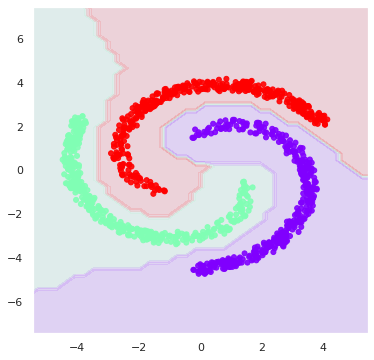

Epoch 451 ( 451) | loss 0.020 | LR 0.0010 | beta 1.0000 | jac 0.021547220647335052
Epoch 452 ( 452) | loss 0.019 | LR 0.0010 | beta 1.0000 | jac 0.020857732743024826
Epoch 453 ( 453) | loss 0.019 | LR 0.0010 | beta 1.0000 | jac 0.03796936944127083
Epoch 454 ( 454) | loss 0.018 | LR 0.0010 | beta 1.0000 | jac 0.016743777319788933
Epoch 455 ( 455) | loss 0.018 | LR 0.0010 | beta 1.0000 | jac 0.1751100718975067
Epoch 456 ( 456) | loss 0.018 | LR 0.0010 | beta 1.0000 | jac 0.020342692732810974
Epoch 457 ( 457) | loss 0.018 | LR 0.0010 | beta 1.0000 | jac 0.02743794210255146
Epoch 458 ( 458) | loss 0.019 | LR 0.0010 | beta 1.0000 | jac 0.029298363253474236
Epoch 459 ( 459) | loss 0.020 | LR 0.0010 | beta 1.0000 | jac 0.046987466514110565
Epoch 460 ( 460) | loss 0.020 | LR 0.0010 | beta 1.0000 | jac 0.036803219467401505


<Figure size 360x216 with 0 Axes>

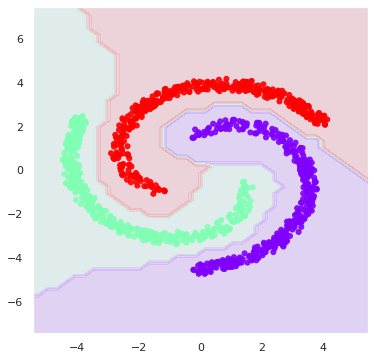

Epoch 461 ( 461) | loss 0.019 | LR 0.0010 | beta 1.0000 | jac 0.028118330985307693
Epoch 462 ( 462) | loss 0.020 | LR 0.0010 | beta 1.0000 | jac 0.042934197932481766
Epoch 463 ( 463) | loss 0.020 | LR 0.0010 | beta 1.0000 | jac 0.024209048599004745
Epoch 464 ( 464) | loss 0.020 | LR 0.0010 | beta 1.0000 | jac 0.020862804725766182
Epoch 465 ( 465) | loss 0.019 | LR 0.0010 | beta 1.0000 | jac 0.021554578095674515
Epoch 466 ( 466) | loss 0.018 | LR 0.0010 | beta 1.0000 | jac 0.023281579837203026
Epoch 467 ( 467) | loss 0.018 | LR 0.0010 | beta 1.0000 | jac 0.028575224801898003
Epoch 468 ( 468) | loss 0.017 | LR 0.0010 | beta 1.0000 | jac 0.03276011720299721
Epoch 469 ( 469) | loss 0.017 | LR 0.0010 | beta 1.0000 | jac 0.017958128824830055
Epoch 470 ( 470) | loss 0.017 | LR 0.0010 | beta 1.0000 | jac 0.020698849111795425


<Figure size 360x216 with 0 Axes>

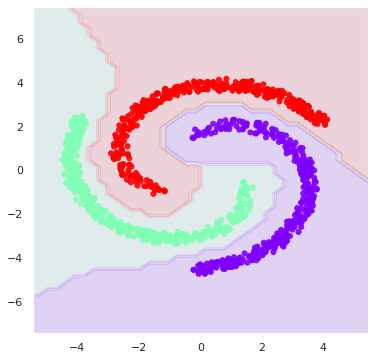

Epoch 471 ( 471) | loss 0.016 | LR 0.0010 | beta 1.0000 | jac 0.01868303492665291
Epoch 472 ( 472) | loss 0.016 | LR 0.0010 | beta 1.0000 | jac 0.018064605072140694
Epoch 473 ( 473) | loss 0.015 | LR 0.0010 | beta 1.0000 | jac 0.020066920667886734
Epoch 474 ( 474) | loss 0.015 | LR 0.0010 | beta 1.0000 | jac 0.01602626033127308
Epoch 475 ( 475) | loss 0.014 | LR 0.0010 | beta 1.0000 | jac 0.017705125734210014
Epoch 476 ( 476) | loss 0.014 | LR 0.0010 | beta 1.0000 | jac 0.014170603826642036
Epoch 477 ( 477) | loss 0.014 | LR 0.0010 | beta 1.0000 | jac 0.04638558253645897
Epoch 478 ( 478) | loss 0.013 | LR 0.0010 | beta 1.0000 | jac 0.018722940236330032
Epoch 479 ( 479) | loss 0.013 | LR 0.0010 | beta 1.0000 | jac 0.014216752722859383
Epoch 480 ( 480) | loss 0.013 | LR 0.0010 | beta 1.0000 | jac 0.031539250165224075


<Figure size 360x216 with 0 Axes>

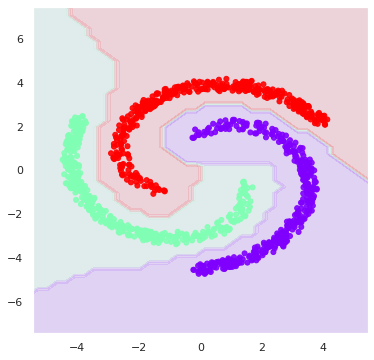

Epoch 481 ( 481) | loss 0.012 | LR 0.0010 | beta 1.0000 | jac 0.029867125675082207
Epoch 482 ( 482) | loss 0.012 | LR 0.0010 | beta 1.0000 | jac 0.011025968007743359
Epoch 483 ( 483) | loss 0.012 | LR 0.0010 | beta 1.0000 | jac 0.012057977728545666
Epoch 484 ( 484) | loss 0.012 | LR 0.0010 | beta 1.0000 | jac 0.018665645271539688
Epoch 485 ( 485) | loss 0.012 | LR 0.0010 | beta 1.0000 | jac 0.01421155035495758
Epoch 486 ( 486) | loss 0.011 | LR 0.0010 | beta 1.0000 | jac 0.018175920471549034
Epoch 487 ( 487) | loss 0.011 | LR 0.0010 | beta 1.0000 | jac 0.015319799073040485
Epoch 488 ( 488) | loss 0.011 | LR 0.0010 | beta 1.0000 | jac 0.01566273346543312
Epoch 489 ( 489) | loss 0.010 | LR 0.0010 | beta 1.0000 | jac 0.016244905069470406
Epoch 490 ( 490) | loss 0.010 | LR 0.0010 | beta 1.0000 | jac 0.010238314978778362


<Figure size 360x216 with 0 Axes>

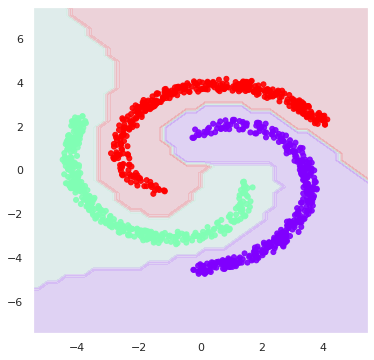

Epoch 491 ( 491) | loss 0.010 | LR 0.0010 | beta 1.0000 | jac 0.011836778372526169
Epoch 492 ( 492) | loss 0.010 | LR 0.0010 | beta 1.0000 | jac 0.03165144845843315
Epoch 493 ( 493) | loss 0.009 | LR 0.0010 | beta 1.0000 | jac 0.008661161176860332
Epoch 494 ( 494) | loss 0.009 | LR 0.0010 | beta 1.0000 | jac 0.009044772014021873
Epoch 495 ( 495) | loss 0.009 | LR 0.0010 | beta 1.0000 | jac 0.015162370167672634
Epoch 496 ( 496) | loss 0.009 | LR 0.0010 | beta 1.0000 | jac 0.009049207903444767
Epoch 497 ( 497) | loss 0.009 | LR 0.0010 | beta 1.0000 | jac 0.008679414168000221
Epoch 498 ( 498) | loss 0.009 | LR 0.0010 | beta 1.0000 | jac 0.007857675664126873
Epoch 499 ( 499) | loss 0.008 | LR 0.0010 | beta 1.0000 | jac 0.008282490074634552
Epoch 500 ( 500) | loss 0.008 | LR 0.0010 | beta 1.0000 | jac 0.013917490839958191


<Figure size 360x216 with 0 Axes>

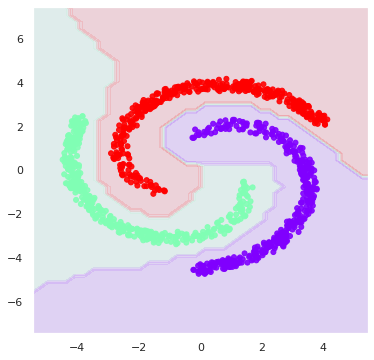

Epoch 501 ( 501) | loss 0.008 | LR 0.0010 | beta 1.0000 | jac 0.008463729172945023
Epoch 502 ( 502) | loss 0.008 | LR 0.0010 | beta 1.0000 | jac 0.06329244375228882
Epoch 503 ( 503) | loss 0.008 | LR 0.0010 | beta 1.0000 | jac 0.010217203758656979
Epoch 504 ( 504) | loss 0.008 | LR 0.0010 | beta 1.0000 | jac 0.01376917865127325
Epoch 505 ( 505) | loss 0.008 | LR 0.0010 | beta 1.0000 | jac 0.013260639272630215
Epoch 506 ( 506) | loss 0.008 | LR 0.0010 | beta 1.0000 | jac 0.018664520233869553
Epoch 507 ( 507) | loss 0.008 | LR 0.0010 | beta 1.0000 | jac 0.010525327175855637
Epoch 508 ( 508) | loss 0.008 | LR 0.0010 | beta 1.0000 | jac 0.04149390384554863
Epoch 509 ( 509) | loss 0.008 | LR 0.0010 | beta 1.0000 | jac 0.01742221787571907
Epoch 510 ( 510) | loss 0.008 | LR 0.0010 | beta 1.0000 | jac 0.015277803875505924


<Figure size 360x216 with 0 Axes>

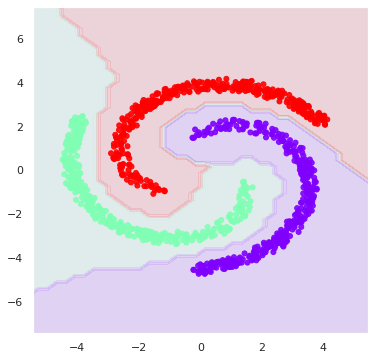

Epoch 511 ( 511) | loss 0.008 | LR 0.0010 | beta 1.0000 | jac 0.013231123797595501
Epoch 512 ( 512) | loss 0.008 | LR 0.0010 | beta 1.0000 | jac 0.012955185025930405
Epoch 513 ( 513) | loss 0.008 | LR 0.0010 | beta 1.0000 | jac 0.015804383903741837
Epoch 514 ( 514) | loss 0.008 | LR 0.0010 | beta 1.0000 | jac 0.01677815616130829
Epoch 515 ( 515) | loss 0.007 | LR 0.0010 | beta 1.0000 | jac 0.014763633720576763
Epoch 516 ( 516) | loss 0.007 | LR 0.0010 | beta 1.0000 | jac 0.013967075385153294
Epoch 517 ( 517) | loss 0.007 | LR 0.0010 | beta 1.0000 | jac 0.10594687610864639
Epoch 518 ( 518) | loss 0.007 | LR 0.0010 | beta 1.0000 | jac 0.02003476209938526
Epoch 519 ( 519) | loss 0.008 | LR 0.0010 | beta 1.0000 | jac 0.02492404915392399
Epoch 520 ( 520) | loss 0.008 | LR 0.0010 | beta 1.0000 | jac 0.03422406688332558


<Figure size 360x216 with 0 Axes>

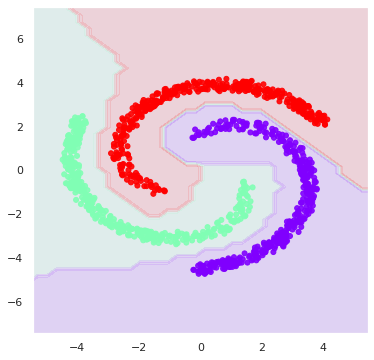

Epoch 521 ( 521) | loss 0.009 | LR 0.0010 | beta 1.0000 | jac 0.03995567187666893
Epoch 522 ( 522) | loss 0.010 | LR 0.0010 | beta 1.0000 | jac 0.02810606360435486
Epoch 523 ( 523) | loss 0.010 | LR 0.0010 | beta 1.0000 | jac 0.03629571944475174
Epoch 524 ( 524) | loss 0.010 | LR 0.0010 | beta 1.0000 | jac 0.05853251740336418
Epoch 525 ( 525) | loss 0.010 | LR 0.0010 | beta 1.0000 | jac 0.06971731781959534
Epoch 526 ( 526) | loss 0.010 | LR 0.0010 | beta 1.0000 | jac 0.030392181128263474
Epoch 527 ( 527) | loss 0.010 | LR 0.0010 | beta 1.0000 | jac 0.02280443161725998
Epoch 528 ( 528) | loss 0.010 | LR 0.0010 | beta 1.0000 | jac 0.03185496851801872
Epoch 529 ( 529) | loss 0.010 | LR 0.0010 | beta 1.0000 | jac 0.028326353058218956
Epoch 530 ( 530) | loss 0.010 | LR 0.0010 | beta 1.0000 | jac 0.031668148934841156


<Figure size 360x216 with 0 Axes>

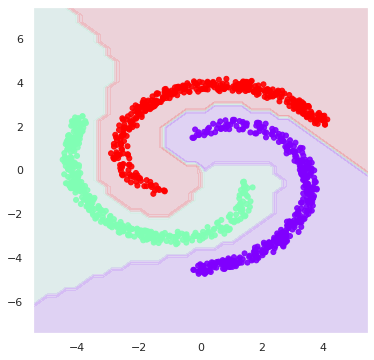

Epoch 531 ( 531) | loss 0.010 | LR 0.0010 | beta 1.0000 | jac 0.027643611654639244
Epoch 532 ( 532) | loss 0.010 | LR 0.0010 | beta 1.0000 | jac 0.03164288401603699
Epoch 533 ( 533) | loss 0.010 | LR 0.0010 | beta 1.0000 | jac 0.027407968416810036
Epoch 534 ( 534) | loss 0.010 | LR 0.0010 | beta 1.0000 | jac 0.02303262986242771
Epoch 535 ( 535) | loss 0.010 | LR 0.0010 | beta 1.0000 | jac 0.03326642885804176
Epoch 536 ( 536) | loss 0.010 | LR 0.0010 | beta 1.0000 | jac 0.01759745553135872
Epoch 537 ( 537) | loss 0.010 | LR 0.0010 | beta 1.0000 | jac 0.02201450988650322
Epoch 538 ( 538) | loss 0.010 | LR 0.0010 | beta 1.0000 | jac 0.018726807087659836
Epoch 539 ( 539) | loss 0.010 | LR 0.0010 | beta 1.0000 | jac 0.039582278579473495
Epoch 540 ( 540) | loss 0.010 | LR 0.0010 | beta 1.0000 | jac 0.0190055500715971


<Figure size 360x216 with 0 Axes>

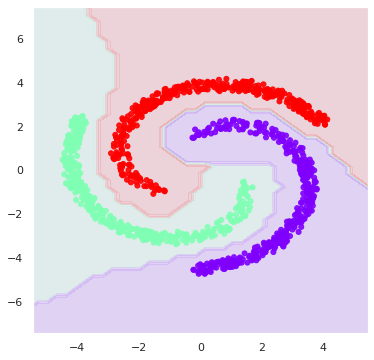

Epoch 541 ( 541) | loss 0.010 | LR 0.0010 | beta 1.0000 | jac 0.017422523349523544
Epoch 542 ( 542) | loss 0.010 | LR 0.0010 | beta 1.0000 | jac 0.01864873431622982
Epoch 543 ( 543) | loss 0.010 | LR 0.0010 | beta 1.0000 | jac 0.01829894818365574
Epoch 544 ( 544) | loss 0.010 | LR 0.0010 | beta 1.0000 | jac 0.014863367192447186
Epoch 545 ( 545) | loss 0.010 | LR 0.0010 | beta 1.0000 | jac 0.014655870385468006
Epoch 546 ( 546) | loss 0.010 | LR 0.0010 | beta 1.0000 | jac 0.013904521241784096
Epoch 547 ( 547) | loss 0.010 | LR 0.0010 | beta 1.0000 | jac 0.022554542869329453
Epoch 548 ( 548) | loss 0.010 | LR 0.0010 | beta 1.0000 | jac 0.014600051566958427
Epoch 549 ( 549) | loss 0.009 | LR 0.0010 | beta 1.0000 | jac 0.0117883225902915
Epoch 550 ( 550) | loss 0.009 | LR 0.0010 | beta 1.0000 | jac 0.02797221578657627


<Figure size 360x216 with 0 Axes>

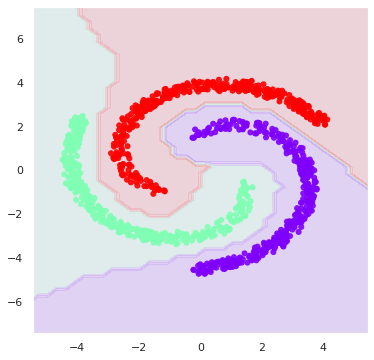

Epoch 551 ( 551) | loss 0.009 | LR 0.0010 | beta 1.0000 | jac 0.011363241821527481
Epoch 552 ( 552) | loss 0.009 | LR 0.0010 | beta 1.0000 | jac 0.011930914595723152
Epoch 553 ( 553) | loss 0.009 | LR 0.0010 | beta 1.0000 | jac 0.015962034463882446
Epoch 554 ( 554) | loss 0.009 | LR 0.0010 | beta 1.0000 | jac 0.012565074488520622
Epoch 555 ( 555) | loss 0.009 | LR 0.0010 | beta 1.0000 | jac 0.014688720926642418
Epoch 556 ( 556) | loss 0.008 | LR 0.0010 | beta 1.0000 | jac 0.011880801990628242
Epoch 557 ( 557) | loss 0.008 | LR 0.0010 | beta 1.0000 | jac 0.010203956626355648
Epoch 558 ( 558) | loss 0.008 | LR 0.0010 | beta 1.0000 | jac 0.01008788961917162
Epoch 559 ( 559) | loss 0.008 | LR 0.0010 | beta 1.0000 | jac 0.012119955383241177
Epoch 560 ( 560) | loss 0.008 | LR 0.0010 | beta 1.0000 | jac 0.01890329085290432


<Figure size 360x216 with 0 Axes>

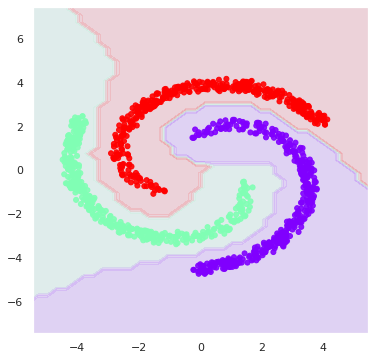

Epoch 561 ( 561) | loss 0.008 | LR 0.0010 | beta 1.0000 | jac 0.012815016321837902
Epoch 562 ( 562) | loss 0.008 | LR 0.0010 | beta 1.0000 | jac 0.008917378261685371
Epoch 563 ( 563) | loss 0.008 | LR 0.0010 | beta 1.0000 | jac 0.011129260063171387
Epoch 564 ( 564) | loss 0.007 | LR 0.0010 | beta 1.0000 | jac 0.007938024587929249
Epoch 565 ( 565) | loss 0.007 | LR 0.0010 | beta 1.0000 | jac 0.006064925342798233
Epoch 566 ( 566) | loss 0.007 | LR 0.0010 | beta 1.0000 | jac 0.007741332054138184
Epoch 567 ( 567) | loss 0.007 | LR 0.0010 | beta 1.0000 | jac 0.025849781930446625
Epoch 568 ( 568) | loss 0.007 | LR 0.0010 | beta 1.0000 | jac 0.012019895017147064
Epoch 569 ( 569) | loss 0.007 | LR 0.0010 | beta 1.0000 | jac 0.0075852093286812305
Epoch 570 ( 570) | loss 0.007 | LR 0.0010 | beta 1.0000 | jac 0.010558710433542728


<Figure size 360x216 with 0 Axes>

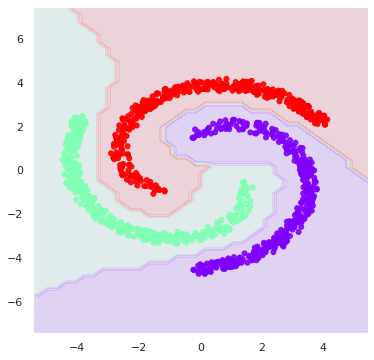

Epoch 571 ( 571) | loss 0.006 | LR 0.0010 | beta 1.0000 | jac 0.007891538552939892
Epoch 572 ( 572) | loss 0.006 | LR 0.0010 | beta 1.0000 | jac 0.022970041260123253
Epoch 573 ( 573) | loss 0.006 | LR 0.0010 | beta 1.0000 | jac 0.00859788153320551
Epoch 574 ( 574) | loss 0.006 | LR 0.0010 | beta 1.0000 | jac 0.00925428420305252
Epoch 575 ( 575) | loss 0.006 | LR 0.0010 | beta 1.0000 | jac 0.006325460504740477
Epoch 576 ( 576) | loss 0.006 | LR 0.0010 | beta 1.0000 | jac 0.00844420213252306
Epoch 577 ( 577) | loss 0.006 | LR 0.0010 | beta 1.0000 | jac 0.0071245464496314526
Epoch 578 ( 578) | loss 0.006 | LR 0.0010 | beta 1.0000 | jac 0.011154943145811558
Epoch 579 ( 579) | loss 0.006 | LR 0.0010 | beta 1.0000 | jac 0.007423259783536196
Epoch 580 ( 580) | loss 0.006 | LR 0.0010 | beta 1.0000 | jac 0.0069480533711612225


<Figure size 360x216 with 0 Axes>

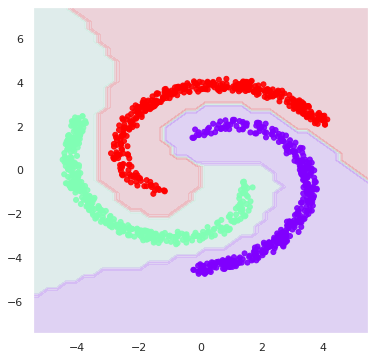

Epoch 581 ( 581) | loss 0.006 | LR 0.0010 | beta 1.0000 | jac 0.0056243292056024075
Epoch 582 ( 582) | loss 0.006 | LR 0.0010 | beta 1.0000 | jac 0.005837608594447374
Epoch 583 ( 583) | loss 0.005 | LR 0.0010 | beta 1.0000 | jac 0.007317858748137951
Epoch 584 ( 584) | loss 0.005 | LR 0.0010 | beta 1.0000 | jac 0.0053184544667601585
Epoch 585 ( 585) | loss 0.005 | LR 0.0010 | beta 1.0000 | jac 0.006576122250407934
Epoch 586 ( 586) | loss 0.005 | LR 0.0010 | beta 1.0000 | jac 0.006758253555744886
Epoch 587 ( 587) | loss 0.005 | LR 0.0010 | beta 1.0000 | jac 0.0073421066626906395
Epoch 588 ( 588) | loss 0.005 | LR 0.0010 | beta 1.0000 | jac 0.00878201425075531
Epoch 589 ( 589) | loss 0.005 | LR 0.0010 | beta 1.0000 | jac 0.018071556463837624
Epoch 590 ( 590) | loss 0.005 | LR 0.0010 | beta 1.0000 | jac 0.007822403684258461


<Figure size 360x216 with 0 Axes>

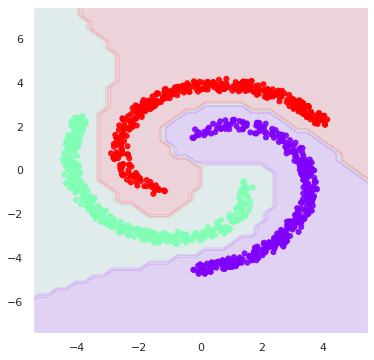

Epoch 591 ( 591) | loss 0.005 | LR 0.0010 | beta 1.0000 | jac 0.0054435101337730885
Epoch 592 ( 592) | loss 0.005 | LR 0.0010 | beta 1.0000 | jac 0.005645494908094406
Epoch 593 ( 593) | loss 0.005 | LR 0.0010 | beta 1.0000 | jac 0.0049256193451583385
Epoch 594 ( 594) | loss 0.005 | LR 0.0010 | beta 1.0000 | jac 0.00625590980052948
Epoch 595 ( 595) | loss 0.005 | LR 0.0010 | beta 1.0000 | jac 0.007084404584020376
Epoch 596 ( 596) | loss 0.005 | LR 0.0010 | beta 1.0000 | jac 0.005436917766928673
Epoch 597 ( 597) | loss 0.004 | LR 0.0010 | beta 1.0000 | jac 0.006635015364736319
Epoch 598 ( 598) | loss 0.004 | LR 0.0010 | beta 1.0000 | jac 0.005510883405804634
Epoch 599 ( 599) | loss 0.004 | LR 0.0010 | beta 1.0000 | jac 0.005503416992723942
Epoch 600 ( 600) | loss 0.004 | LR 0.0010 | beta 1.0000 | jac 0.00782916322350502


<Figure size 360x216 with 0 Axes>

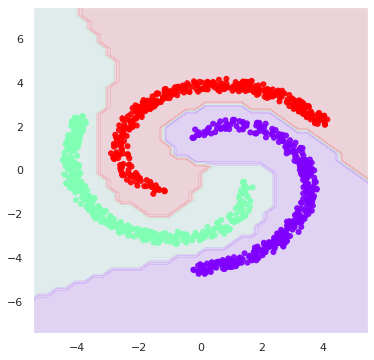

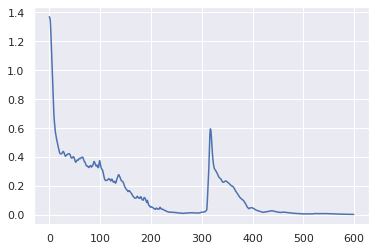

In [20]:
config.beta = 1
config.dim_out=3
config.EPOCHS = 600
config.bs=1200
X,Y, Proj = twospirals(n_points=400, angle=100, hd=True)
loss_list,model,flag = train_DML(plot=True, config=config, data=(X,Y), Proj=Proj)
plt.plot(loss_list)
plt.show()

<Figure size 360x216 with 0 Axes>

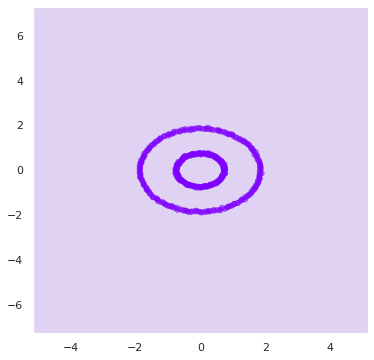

Epoch   1 (   1) | loss 1.366 | LR 0.0010 | beta 3.0000 | jac 0.18591472506523132
Epoch   2 (   2) | loss 1.381 | LR 0.0010 | beta 3.0000 | jac 0.156411275267601
Epoch   3 (   3) | loss 1.374 | LR 0.0010 | beta 3.0000 | jac 0.07207339257001877
Epoch   4 (   4) | loss 1.372 | LR 0.0010 | beta 3.0000 | jac 0.05323157086968422
Epoch   5 (   5) | loss 1.372 | LR 0.0010 | beta 3.0000 | jac 0.041328370571136475
Epoch   6 (   6) | loss 1.368 | LR 0.0010 | beta 3.0000 | jac 0.03508727625012398
Epoch   7 (   7) | loss 1.360 | LR 0.0010 | beta 3.0000 | jac 0.03300189599394798
Epoch   8 (   8) | loss 1.345 | LR 0.0010 | beta 3.0000 | jac 0.03999359905719757
Epoch   9 (   9) | loss 1.321 | LR 0.0010 | beta 3.0000 | jac 0.04958821088075638
Epoch  10 (  10) | loss 1.291 | LR 0.0010 | beta 3.0000 | jac 0.05605132132768631


<Figure size 360x216 with 0 Axes>

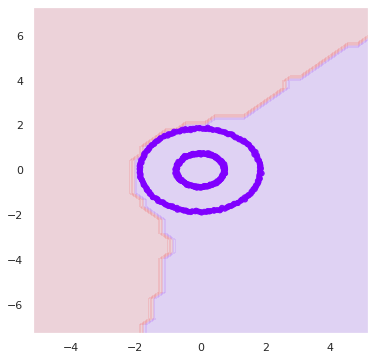

Epoch  11 (  11) | loss 1.257 | LR 0.0010 | beta 3.0000 | jac 0.07085903733968735
Epoch  12 (  12) | loss 1.219 | LR 0.0010 | beta 3.0000 | jac 0.0807579755783081
Epoch  13 (  13) | loss 1.177 | LR 0.0010 | beta 3.0000 | jac 0.13256330788135529
Epoch  14 (  14) | loss 1.136 | LR 0.0010 | beta 3.0000 | jac 0.09915083646774292
Epoch  15 (  15) | loss 1.107 | LR 0.0010 | beta 3.0000 | jac 0.09259601682424545
Epoch  16 (  16) | loss 1.074 | LR 0.0010 | beta 3.0000 | jac 0.09900607168674469
Epoch  17 (  17) | loss 1.027 | LR 0.0010 | beta 3.0000 | jac 0.15205124020576477
Epoch  18 (  18) | loss 0.967 | LR 0.0010 | beta 3.0000 | jac 0.1148231253027916
Epoch  19 (  19) | loss 0.911 | LR 0.0010 | beta 3.0000 | jac 0.13098463416099548
Epoch  20 (  20) | loss 0.852 | LR 0.0010 | beta 3.0000 | jac 0.12986932694911957


<Figure size 360x216 with 0 Axes>

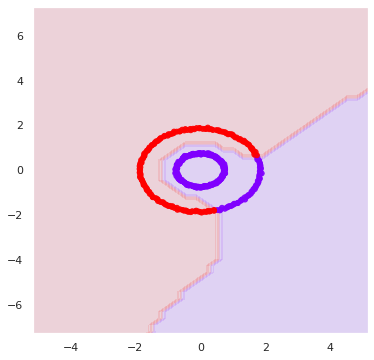

Epoch  21 (  21) | loss 0.800 | LR 0.0010 | beta 3.0000 | jac 0.15715309977531433
Epoch  22 (  22) | loss 0.738 | LR 0.0010 | beta 3.0000 | jac 0.11444487422704697
Epoch  23 (  23) | loss 0.680 | LR 0.0010 | beta 3.0000 | jac 0.16273902356624603
Epoch  24 (  24) | loss 0.631 | LR 0.0010 | beta 3.0000 | jac 0.11444391310214996
Epoch  25 (  25) | loss 0.596 | LR 0.0010 | beta 3.0000 | jac 0.0787147805094719
Epoch  26 (  26) | loss 0.552 | LR 0.0010 | beta 3.0000 | jac 0.10440538823604584
Epoch  27 (  27) | loss 0.501 | LR 0.0010 | beta 3.0000 | jac 0.05295415222644806
Epoch  28 (  28) | loss 0.448 | LR 0.0010 | beta 3.0000 | jac 0.07800748944282532
Epoch  29 (  29) | loss 0.394 | LR 0.0010 | beta 3.0000 | jac 0.04846211150288582
Epoch  30 (  30) | loss 0.345 | LR 0.0010 | beta 3.0000 | jac 0.05107562988996506


<Figure size 360x216 with 0 Axes>

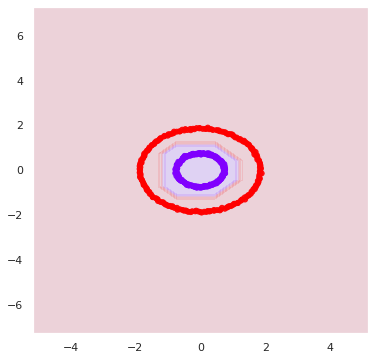

Epoch  31 (  31) | loss 0.302 | LR 0.0010 | beta 3.0000 | jac 0.024505920708179474
Epoch  32 (  32) | loss 0.264 | LR 0.0010 | beta 3.0000 | jac 0.11122303456068039
Epoch  33 (  33) | loss 0.229 | LR 0.0010 | beta 3.0000 | jac 0.07049261778593063
Epoch  34 (  34) | loss 0.201 | LR 0.0010 | beta 3.0000 | jac 0.04863942041993141
Epoch  35 (  35) | loss 0.175 | LR 0.0010 | beta 3.0000 | jac 0.3577903211116791
Epoch  36 (  36) | loss 0.150 | LR 0.0010 | beta 3.0000 | jac 0.04401248320937157
Epoch  37 (  37) | loss 0.135 | LR 0.0010 | beta 3.0000 | jac 0.2376880943775177
Epoch  38 (  38) | loss 0.121 | LR 0.0010 | beta 3.0000 | jac 0.06489242613315582
Epoch  39 (  39) | loss 0.112 | LR 0.0010 | beta 3.0000 | jac 0.045806631445884705
Epoch  40 (  40) | loss 0.103 | LR 0.0010 | beta 3.0000 | jac 0.7825911045074463


<Figure size 360x216 with 0 Axes>

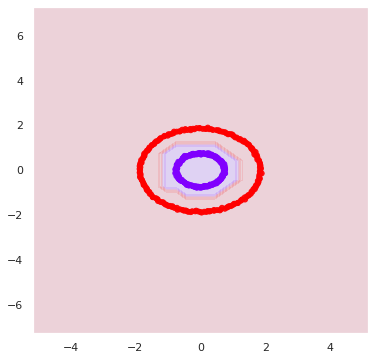

Epoch  41 (  41) | loss 0.094 | LR 0.0010 | beta 3.0000 | jac 0.05272100493311882
Epoch  42 (  42) | loss 0.090 | LR 0.0010 | beta 3.0000 | jac 0.13617262244224548
Epoch  43 (  43) | loss 0.090 | LR 0.0010 | beta 3.0000 | jac 2.219426155090332
Epoch  44 (  44) | loss 0.089 | LR 0.0010 | beta 3.0000 | jac 0.2353155016899109
Epoch  45 (  45) | loss 0.091 | LR 0.0010 | beta 3.0000 | jac 0.38284263014793396
Epoch  46 (  46) | loss 0.102 | LR 0.0010 | beta 3.0000 | jac 1.560376524925232
Epoch  47 (  47) | loss 0.116 | LR 0.0010 | beta 3.0000 | jac 0.4826955199241638
Epoch  48 (  48) | loss 0.120 | LR 0.0010 | beta 3.0000 | jac 0.18082286417484283
Epoch  49 (  49) | loss 0.131 | LR 0.0010 | beta 3.0000 | jac 0.16556265950202942
Epoch  50 (  50) | loss 0.147 | LR 0.0010 | beta 3.0000 | jac 0.1816069781780243


<Figure size 360x216 with 0 Axes>

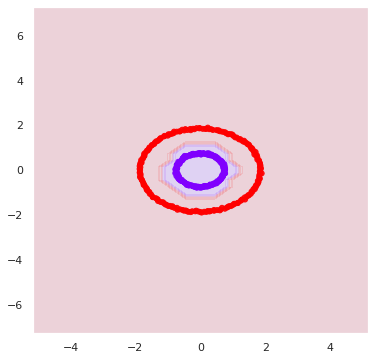

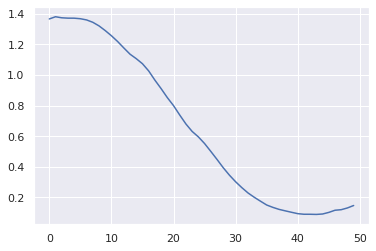

In [23]:
config.beta = 3
config.dim_out=2
config.bs=400
config.EPOCHS = 50
X,Y, Proj = get_circles_data(n_samples=400, noise=0.01, factor=0.4,  hd=True)
loss_list,model,flag = train_DML(plot=True, config=config, data=(X,Y), Proj=Proj)
plt.plot(loss_list)
plt.show()


<Figure size 360x216 with 0 Axes>

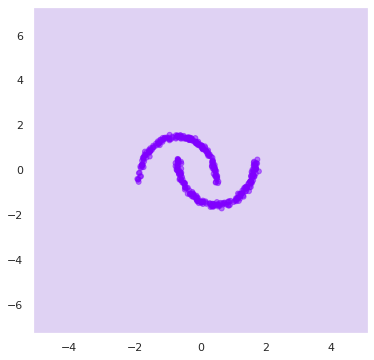

Epoch   1 (   1) | loss 1.375 | LR 0.0010 | beta 3.0000 | jac 0.2879643440246582
Epoch   2 (   2) | loss 1.365 | LR 0.0010 | beta 3.0000 | jac 0.30131277441978455
Epoch   3 (   3) | loss 1.365 | LR 0.0010 | beta 3.0000 | jac 0.1706668585538864
Epoch   4 (   4) | loss 1.357 | LR 0.0010 | beta 3.0000 | jac 0.11722348630428314
Epoch   5 (   5) | loss 1.323 | LR 0.0010 | beta 3.0000 | jac 0.07414261996746063
Epoch   6 (   6) | loss 1.293 | LR 0.0010 | beta 3.0000 | jac 0.09767287969589233
Epoch   7 (   7) | loss 1.240 | LR 0.0010 | beta 3.0000 | jac 0.08048909902572632
Epoch   8 (   8) | loss 1.172 | LR 0.0010 | beta 3.0000 | jac 0.10508300364017487
Epoch   9 (   9) | loss 1.093 | LR 0.0010 | beta 3.0000 | jac 0.1463758498430252
Epoch  10 (  10) | loss 1.015 | LR 0.0010 | beta 3.0000 | jac 0.1389860063791275


<Figure size 360x216 with 0 Axes>

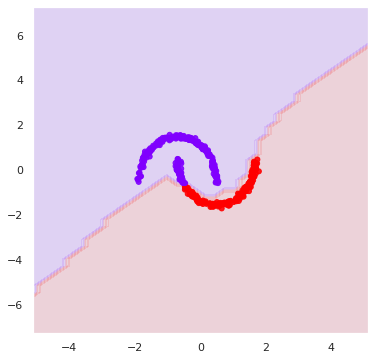

Epoch  11 (  11) | loss 0.948 | LR 0.0010 | beta 3.0000 | jac 0.14185667037963867
Epoch  12 (  12) | loss 0.887 | LR 0.0010 | beta 3.0000 | jac 0.16131165623664856
Epoch  13 (  13) | loss 0.828 | LR 0.0010 | beta 3.0000 | jac 0.15573887526988983
Epoch  14 (  14) | loss 0.773 | LR 0.0010 | beta 3.0000 | jac 0.19224493205547333
Epoch  15 (  15) | loss 0.722 | LR 0.0010 | beta 3.0000 | jac 0.18166644871234894
Epoch  16 (  16) | loss 0.675 | LR 0.0010 | beta 3.0000 | jac 0.15683545172214508
Epoch  17 (  17) | loss 0.636 | LR 0.0010 | beta 3.0000 | jac 0.1498844176530838
Epoch  18 (  18) | loss 0.597 | LR 0.0010 | beta 3.0000 | jac 0.22048501670360565
Epoch  19 (  19) | loss 0.557 | LR 0.0010 | beta 3.0000 | jac 0.1567610651254654
Epoch  20 (  20) | loss 0.525 | LR 0.0010 | beta 3.0000 | jac 0.12165122479200363


<Figure size 360x216 with 0 Axes>

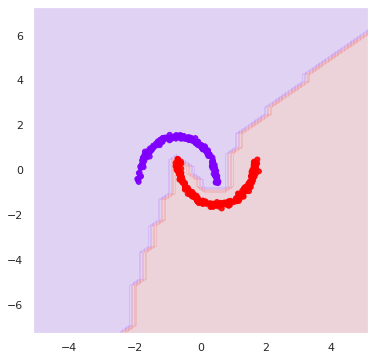

Epoch  21 (  21) | loss 0.488 | LR 0.0010 | beta 3.0000 | jac 0.144495889544487
Epoch  22 (  22) | loss 0.453 | LR 0.0010 | beta 3.0000 | jac 0.2004665732383728
Epoch  23 (  23) | loss 0.421 | LR 0.0010 | beta 3.0000 | jac 0.30895739793777466
Epoch  24 (  24) | loss 0.393 | LR 0.0010 | beta 3.0000 | jac 0.15450656414031982
Epoch  25 (  25) | loss 0.380 | LR 0.0010 | beta 3.0000 | jac 0.10301073640584946
Epoch  26 (  26) | loss 0.351 | LR 0.0010 | beta 3.0000 | jac 0.12132152915000916
Epoch  27 (  27) | loss 0.320 | LR 0.0010 | beta 3.0000 | jac 0.5978044271469116
Epoch  28 (  28) | loss 0.298 | LR 0.0010 | beta 3.0000 | jac 0.24979513883590698
Epoch  29 (  29) | loss 0.295 | LR 0.0010 | beta 3.0000 | jac 0.2681664526462555
Epoch  30 (  30) | loss 0.289 | LR 0.0010 | beta 3.0000 | jac 0.14520668983459473


<Figure size 360x216 with 0 Axes>

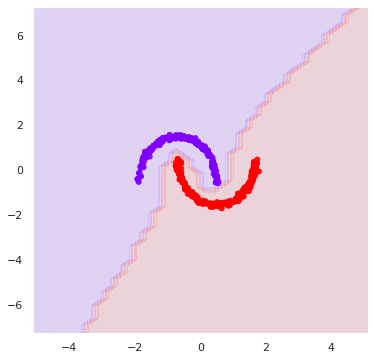

Epoch  31 (  31) | loss 0.280 | LR 0.0010 | beta 3.0000 | jac 0.12291383743286133
Epoch  32 (  32) | loss 0.269 | LR 0.0010 | beta 3.0000 | jac 0.12144450098276138
Epoch  33 (  33) | loss 0.258 | LR 0.0010 | beta 3.0000 | jac 0.08685958385467529
Epoch  34 (  34) | loss 0.247 | LR 0.0010 | beta 3.0000 | jac 0.06507761031389236
Epoch  35 (  35) | loss 0.234 | LR 0.0010 | beta 3.0000 | jac 0.09515827149152756
Epoch  36 (  36) | loss 0.217 | LR 0.0010 | beta 3.0000 | jac 0.07968621701002121
Epoch  37 (  37) | loss 0.199 | LR 0.0010 | beta 3.0000 | jac 0.10653318464756012
Epoch  38 (  38) | loss 0.185 | LR 0.0010 | beta 3.0000 | jac 0.06900297850370407
Epoch  39 (  39) | loss 0.174 | LR 0.0010 | beta 3.0000 | jac 0.04406798630952835
Epoch  40 (  40) | loss 0.163 | LR 0.0010 | beta 3.0000 | jac 0.09285181760787964


<Figure size 360x216 with 0 Axes>

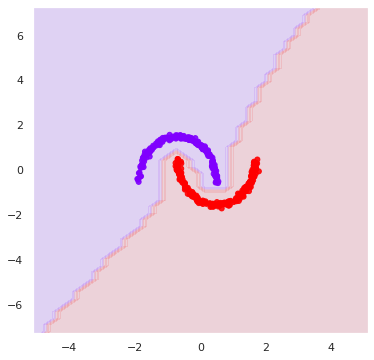

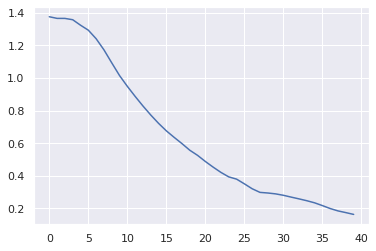

In [24]:
config.beta = 3
config.dim_out=2
config.bs=400
config.EPOCHS = 40
X,Y,X_test,Y_test, Proj = get_moon_data(n_samples=400, n_samples_test=1000, noise=0.03, outlier_distance=2, hd=True)
loss_list,model,flag = train_DML(plot=True, config=config, data=(X,Y), Proj=Proj)
plt.plot(loss_list)
plt.show()


<Figure size 360x216 with 0 Axes>

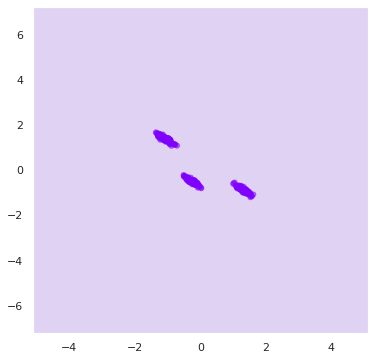

Epoch   1 (   1) | loss 1.372 | LR 0.0010 | beta 3.0000 | jac 3.4276235103607178
Epoch   2 (   2) | loss 1.362 | LR 0.0010 | beta 3.0000 | jac 0.6309942007064819
Epoch   3 (   3) | loss 1.366 | LR 0.0010 | beta 3.0000 | jac 1.2602239847183228
Epoch   4 (   4) | loss 1.376 | LR 0.0010 | beta 3.0000 | jac 0.9586619138717651
Epoch   5 (   5) | loss 1.367 | LR 0.0010 | beta 3.0000 | jac 0.20493590831756592
Epoch   6 (   6) | loss 1.361 | LR 0.0010 | beta 3.0000 | jac 0.12236079573631287
Epoch   7 (   7) | loss 1.351 | LR 0.0010 | beta 3.0000 | jac 0.07897235453128815
Epoch   8 (   8) | loss 1.348 | LR 0.0010 | beta 3.0000 | jac 0.05440865829586983
Epoch   9 (   9) | loss 1.345 | LR 0.0010 | beta 3.0000 | jac 0.02794993668794632
Epoch  10 (  10) | loss 1.341 | LR 0.0010 | beta 3.0000 | jac 0.023235559463500977


<Figure size 360x216 with 0 Axes>

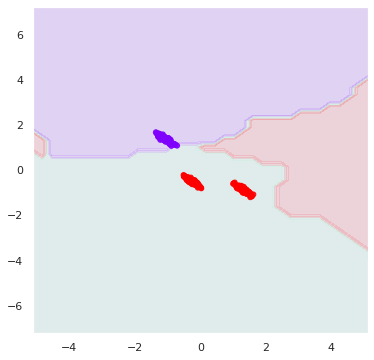

Epoch  11 (  11) | loss 1.336 | LR 0.0010 | beta 3.0000 | jac 0.031905315816402435
Epoch  12 (  12) | loss 1.331 | LR 0.0010 | beta 3.0000 | jac 0.02544357068836689
Epoch  13 (  13) | loss 1.325 | LR 0.0010 | beta 3.0000 | jac 0.019847696647047997
Epoch  14 (  14) | loss 1.319 | LR 0.0010 | beta 3.0000 | jac 0.01510868314653635
Epoch  15 (  15) | loss 1.312 | LR 0.0010 | beta 3.0000 | jac 0.013417025096714497
Epoch  16 (  16) | loss 1.305 | LR 0.0010 | beta 3.0000 | jac 0.010897789150476456
Epoch  17 (  17) | loss 1.298 | LR 0.0010 | beta 3.0000 | jac 0.010775016620755196
Epoch  18 (  18) | loss 1.289 | LR 0.0010 | beta 3.0000 | jac 0.012949344702064991
Epoch  19 (  19) | loss 1.280 | LR 0.0010 | beta 3.0000 | jac 0.013329217210412025
Epoch  20 (  20) | loss 1.269 | LR 0.0010 | beta 3.0000 | jac 0.012274415232241154


<Figure size 360x216 with 0 Axes>

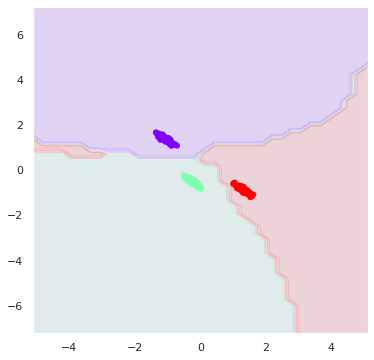

Epoch  21 (  21) | loss 1.258 | LR 0.0010 | beta 3.0000 | jac 0.01406477764248848
Epoch  22 (  22) | loss 1.245 | LR 0.0010 | beta 3.0000 | jac 0.014345122501254082
Epoch  23 (  23) | loss 1.231 | LR 0.0010 | beta 3.0000 | jac 0.018229270353913307
Epoch  24 (  24) | loss 1.216 | LR 0.0010 | beta 3.0000 | jac 0.010371723212301731
Epoch  25 (  25) | loss 1.201 | LR 0.0010 | beta 3.0000 | jac 0.009967448189854622
Epoch  26 (  26) | loss 1.187 | LR 0.0010 | beta 3.0000 | jac 0.02069411799311638
Epoch  27 (  27) | loss 1.171 | LR 0.0010 | beta 3.0000 | jac 0.008898124098777771
Epoch  28 (  28) | loss 1.156 | LR 0.0010 | beta 3.0000 | jac 0.012353867292404175
Epoch  29 (  29) | loss 1.140 | LR 0.0010 | beta 3.0000 | jac 0.008037388324737549
Epoch  30 (  30) | loss 1.122 | LR 0.0010 | beta 3.0000 | jac 0.007207972928881645


<Figure size 360x216 with 0 Axes>

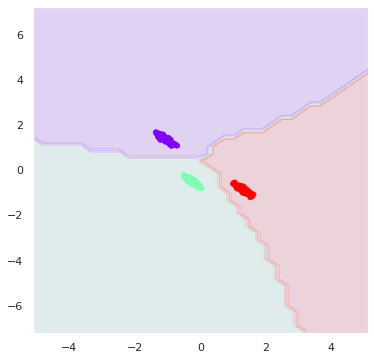

Epoch  31 (  31) | loss 1.104 | LR 0.0010 | beta 3.0000 | jac 0.013063606806099415
Epoch  32 (  32) | loss 1.085 | LR 0.0010 | beta 3.0000 | jac 0.01226785872131586
Epoch  33 (  33) | loss 1.065 | LR 0.0010 | beta 3.0000 | jac 0.020152132958173752
Epoch  34 (  34) | loss 1.045 | LR 0.0010 | beta 3.0000 | jac 0.033618856221437454
Epoch  35 (  35) | loss 1.025 | LR 0.0010 | beta 3.0000 | jac 0.01017354242503643
Epoch  36 (  36) | loss 1.005 | LR 0.0010 | beta 3.0000 | jac 0.015504216775298119
Epoch  37 (  37) | loss 0.983 | LR 0.0010 | beta 3.0000 | jac 0.009125021286308765
Epoch  38 (  38) | loss 0.960 | LR 0.0010 | beta 3.0000 | jac 0.011815501376986504
Epoch  39 (  39) | loss 0.937 | LR 0.0010 | beta 3.0000 | jac 0.016845926642417908
Epoch  40 (  40) | loss 0.912 | LR 0.0010 | beta 3.0000 | jac 0.012487098574638367


<Figure size 360x216 with 0 Axes>

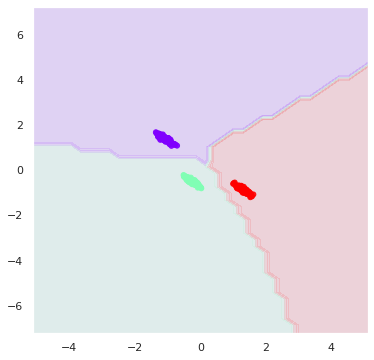

Epoch  41 (  41) | loss 0.888 | LR 0.0010 | beta 3.0000 | jac 0.028215833008289337
Epoch  42 (  42) | loss 0.864 | LR 0.0010 | beta 3.0000 | jac 0.010409303940832615
Epoch  43 (  43) | loss 0.839 | LR 0.0010 | beta 3.0000 | jac 0.012579195201396942
Epoch  44 (  44) | loss 0.814 | LR 0.0010 | beta 3.0000 | jac 0.10858474671840668
Epoch  45 (  45) | loss 0.788 | LR 0.0010 | beta 3.0000 | jac 0.0177235696464777
Epoch  46 (  46) | loss 0.765 | LR 0.0010 | beta 3.0000 | jac 0.00898085068911314
Epoch  47 (  47) | loss 0.742 | LR 0.0010 | beta 3.0000 | jac 0.010188443586230278
Epoch  48 (  48) | loss 0.718 | LR 0.0010 | beta 3.0000 | jac 0.007846455089747906
Epoch  49 (  49) | loss 0.694 | LR 0.0010 | beta 3.0000 | jac 0.016639867797493935
Epoch  50 (  50) | loss 0.670 | LR 0.0010 | beta 3.0000 | jac 0.006334246136248112


<Figure size 360x216 with 0 Axes>

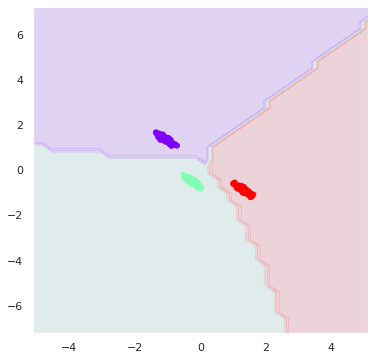

Epoch  51 (  51) | loss 0.646 | LR 0.0010 | beta 3.0000 | jac 0.007276458665728569
Epoch  52 (  52) | loss 0.622 | LR 0.0010 | beta 3.0000 | jac 0.011685454286634922
Epoch  53 (  53) | loss 0.597 | LR 0.0010 | beta 3.0000 | jac 0.008292155340313911
Epoch  54 (  54) | loss 0.573 | LR 0.0010 | beta 3.0000 | jac 0.0059575908817350864
Epoch  55 (  55) | loss 0.549 | LR 0.0010 | beta 3.0000 | jac 0.006164678372442722
Epoch  56 (  56) | loss 0.525 | LR 0.0010 | beta 3.0000 | jac 0.00729749072343111
Epoch  57 (  57) | loss 0.502 | LR 0.0010 | beta 3.0000 | jac 0.005173767916858196
Epoch  58 (  58) | loss 0.480 | LR 0.0010 | beta 3.0000 | jac 0.005567003507167101
Epoch  59 (  59) | loss 0.457 | LR 0.0010 | beta 3.0000 | jac 0.006834341678768396
Epoch  60 (  60) | loss 0.437 | LR 0.0010 | beta 3.0000 | jac 0.006020477972924709


<Figure size 360x216 with 0 Axes>

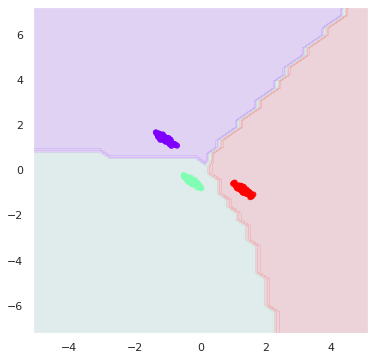

Epoch  61 (  61) | loss 0.417 | LR 0.0010 | beta 3.0000 | jac 0.0045796167105436325
Epoch  62 (  62) | loss 0.398 | LR 0.0010 | beta 3.0000 | jac 0.007100410759449005
Epoch  63 (  63) | loss 0.380 | LR 0.0010 | beta 3.0000 | jac 0.054532475769519806
Epoch  64 (  64) | loss 0.362 | LR 0.0010 | beta 3.0000 | jac 0.009613974019885063
Epoch  65 (  65) | loss 0.346 | LR 0.0010 | beta 3.0000 | jac 0.016391100361943245
Epoch  66 (  66) | loss 0.330 | LR 0.0010 | beta 3.0000 | jac 0.04416496679186821
Epoch  67 (  67) | loss 0.315 | LR 0.0010 | beta 3.0000 | jac 0.03542148321866989
Epoch  68 (  68) | loss 0.301 | LR 0.0010 | beta 3.0000 | jac 0.016552932560443878
Epoch  69 (  69) | loss 0.287 | LR 0.0010 | beta 3.0000 | jac 0.04247087240219116
Epoch  70 (  70) | loss 0.274 | LR 0.0010 | beta 3.0000 | jac 0.0063026524148881435


<Figure size 360x216 with 0 Axes>

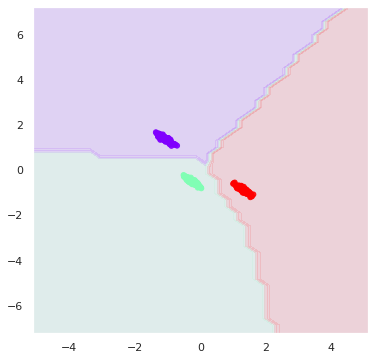

Epoch  71 (  71) | loss 0.262 | LR 0.0010 | beta 3.0000 | jac 0.007540643680840731
Epoch  72 (  72) | loss 0.250 | LR 0.0010 | beta 3.0000 | jac 0.019286923110485077
Epoch  73 (  73) | loss 0.239 | LR 0.0010 | beta 3.0000 | jac 0.00453279260545969
Epoch  74 (  74) | loss 0.228 | LR 0.0010 | beta 3.0000 | jac 0.011071103624999523
Epoch  75 (  75) | loss 0.218 | LR 0.0010 | beta 3.0000 | jac 0.019203724339604378
Epoch  76 (  76) | loss 0.208 | LR 0.0010 | beta 3.0000 | jac 0.0030544186010956764
Epoch  77 (  77) | loss 0.199 | LR 0.0010 | beta 3.0000 | jac 0.003745522815734148
Epoch  78 (  78) | loss 0.190 | LR 0.0010 | beta 3.0000 | jac 0.04189084842801094
Epoch  79 (  79) | loss 0.182 | LR 0.0010 | beta 3.0000 | jac 0.008819116279482841
Epoch  80 (  80) | loss 0.175 | LR 0.0010 | beta 3.0000 | jac 0.004793231841176748


<Figure size 360x216 with 0 Axes>

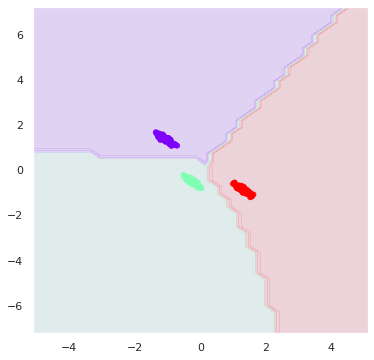

Epoch  81 (  81) | loss 0.167 | LR 0.0010 | beta 3.0000 | jac 0.020833168178796768
Epoch  82 (  82) | loss 0.160 | LR 0.0010 | beta 3.0000 | jac 0.0017469844315201044
Epoch  83 (  83) | loss 0.154 | LR 0.0010 | beta 3.0000 | jac 0.0195723008364439
Epoch  84 (  84) | loss 0.148 | LR 0.0010 | beta 3.0000 | jac 0.0030418969690799713
Epoch  85 (  85) | loss 0.142 | LR 0.0010 | beta 3.0000 | jac 0.00877466332167387
Epoch  86 (  86) | loss 0.137 | LR 0.0010 | beta 3.0000 | jac 0.003139055799692869
Epoch  87 (  87) | loss 0.131 | LR 0.0010 | beta 3.0000 | jac 0.001718337181955576
Epoch  88 (  88) | loss 0.126 | LR 0.0010 | beta 3.0000 | jac 0.0025855645071715117
Epoch  89 (  89) | loss 0.122 | LR 0.0010 | beta 3.0000 | jac 0.0020462987013161182
Epoch  90 (  90) | loss 0.117 | LR 0.0010 | beta 3.0000 | jac 0.00519355945289135


<Figure size 360x216 with 0 Axes>

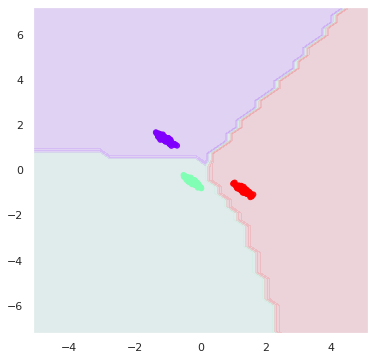

Epoch  91 (  91) | loss 0.113 | LR 0.0010 | beta 3.0000 | jac 0.02098586969077587
Epoch  92 (  92) | loss 0.109 | LR 0.0010 | beta 3.0000 | jac 0.010782034136354923
Epoch  93 (  93) | loss 0.105 | LR 0.0010 | beta 3.0000 | jac 0.00950744841247797
Epoch  94 (  94) | loss 0.102 | LR 0.0010 | beta 3.0000 | jac 0.005190290044993162
Epoch  95 (  95) | loss 0.099 | LR 0.0010 | beta 3.0000 | jac 0.0019143694080412388
Epoch  96 (  96) | loss 0.095 | LR 0.0010 | beta 3.0000 | jac 0.001680985325947404
Epoch  97 (  97) | loss 0.092 | LR 0.0010 | beta 3.0000 | jac 0.003778912825509906
Epoch  98 (  98) | loss 0.090 | LR 0.0010 | beta 3.0000 | jac 0.0014241674216464162
Epoch  99 (  99) | loss 0.087 | LR 0.0010 | beta 3.0000 | jac 0.0016179028898477554
Epoch 100 ( 100) | loss 0.084 | LR 0.0010 | beta 3.0000 | jac 0.0040694475173950195


<Figure size 360x216 with 0 Axes>

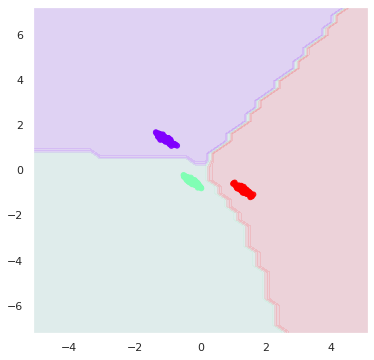

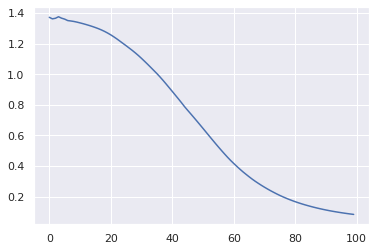

In [27]:
config.beta = 3
config.dim_out=3
config.bs=400
config.EPOCHS = 100
X,Y,X_test,Y_test,Proj = get_blob_data(n_samples=400, n_samples_test=1000, noise=0.3, hd=True)
loss_list,model,flag = train_DML(plot=True, config=config, data=(X,Y), Proj=Proj)
plt.plot(loss_list)
plt.show()